In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from surprise.model_selection import KFold
from tqdm.notebook import tqdm
from sklearn.metrics import ndcg_score
from surprise import dump
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from surprise import SVD
import random
import pickle
from copy import deepcopy

import typing as tp
from sklearn.preprocessing import normalize
from lightfm import LightFM
from scipy.sparse import coo_matrix
from lightfm.data import Dataset as LFMDataset
from collections import Counter
from matplotlib.lines import Line2D
import time
import optuna

np.random.seed(42)

C:\ProgramData\Anaconda3\envs\torchvision\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
from uuu import mapk_plot, mapk, calculate_serendipity_per_user, prediction_coverage, \
catalog_coverage, long_tail_plot, weight_by_volume, get_frame_from_prediction_list, novelty, get_value_popularity_ranks

In [3]:
df = pd.read_csv('../data/recsys-in-practice/train_joke_df.csv')

df['UID'] = df['UID'] - 1
df['JID'] = df['JID'] - 1
# сделаем сортировку и перепишем index
df = df.sort_values(by=['UID', 'JID'])
df = df.reset_index(drop=True)

df

df_train, df_test = train_test_split(df, test_size=0.5, random_state=42)

E:\competitions\kaggle\magnit_recsys-in-practice\part2\uuu.py:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  head = head.append(tail.head(1))


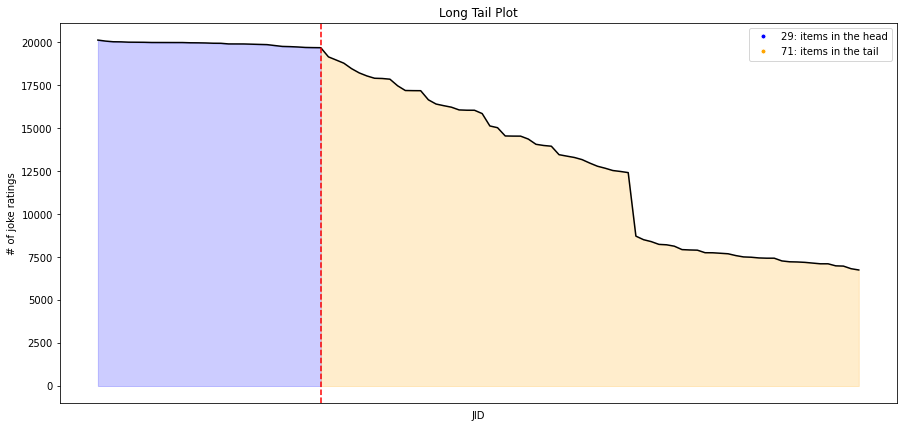

In [4]:
fig = plt.figure(figsize=(15, 7))
volume_df = long_tail_plot(df=df, 
             item_id_column="JID", 
             interaction_type="joke ratings", 
             percentage=0.4,
             x_labels=False)

volume_df['weight'] = volume_df['percent_of_total_volume'].apply(weight_by_volume)
joke_volume = {}
for row in volume_df.itertuples():
    joke_volume[int(row.JID)] = row.weight

In [5]:
df_top_joke = df[df['Rating'] > 5].groupby('JID').agg('count').rename(columns={'Rating':'count_plus'}) \
.sort_values('count_plus', ascending=False).drop(columns=['UID'])


df_bottom_joke = df[df['Rating'] < -5].groupby('JID').agg('count').rename(columns={'Rating':'count_minus'}) \
.sort_values('count_minus', ascending=False).drop(columns=['UID'])


df_counts = df_bottom_joke.merge(df_top_joke, left_index=True, right_index=True)


df_counts['diff'] = df_counts['count_plus'] - df_counts['count_minus']
df_counts = df_counts.sort_values('diff', ascending=False)


df_counts['weight'] = df_counts['diff'] / 10000

joke_quality = {}
for row in df_counts.itertuples():
    joke_quality[row.Index] = row.weight

In [6]:
with open('predictions_df_surprise.pkl', 'rb') as f:
    predictions_df_surprise = pickle.load(f)
    
predictions_df_surprise.keys()

dict_keys(['actual', 'svd', 'knn'])

In [7]:
with open('predictions_df_lfm.pkl', 'rb') as f:
    predictions_df_lfm = pickle.load(f)
    
predictions_df_lfm.keys()

dict_keys(['lfm', 'lfm_cos'])

In [8]:
with open('predictions_df_nn.pkl', 'rb') as f:
    predictions_df_nn = pickle.load(f)
    
predictions_df_nn.keys()

dict_keys(['nn'])

In [9]:
with open('predictions_df_catboost.pkl', 'rb') as f:
    predictions_df_catboost = pickle.load(f)
    
predictions_df_catboost.keys()

dict_keys(['catboost'])

In [10]:
with open('predictions_df_catboost_doc2vec.pkl', 'rb') as f:
    predictions_df_catboost_doc2vec = pickle.load(f)
    
predictions_df_catboost_doc2vec.keys()

dict_keys(['catboost_doc2vec'])

In [11]:
svd_df = predictions_df_surprise['svd']
knn_df = predictions_df_surprise['knn']
lfm_df = predictions_df_lfm['lfm']
lfm_cos_df = predictions_df_lfm['lfm_cos']
nn_df = predictions_df_nn['nn']
catboost_df = predictions_df_catboost['catboost']
catboost_doc2vec_df = predictions_df_catboost_doc2vec['catboost_doc2vec']
actual_df = predictions_df_surprise['actual']

In [12]:
frames = {'svd':svd_df, 'lfm_cos':lfm_cos_df, 'nn':nn_df, 
          'knn':knn_df, 'catboost_doc2vec':catboost_doc2vec_df}

predictions = {k:list(v.groupby('UID').agg({'JID':list})['JID'].values) for k, v in frames.items()}
actual = list(predictions_df_surprise['actual'].groupby('UID').agg({'JID':list})['JID'].values)

In [13]:
users = df["UID"].unique()
n_users = users.size
n_users

24983

In [14]:
# рекомендации по популярным 
#popularity_recs = df['JID'].value_counts().head(10).index.tolist()

#pop_recs = []
#for user in tqdm(range(n_users)):
#    pop_predictions = popularity_recs
#    pop_recs.append(pop_predictions)
    
    
#predictions['popular'] = pop_recs

In [15]:
pop = dict(df.JID.value_counts())

In [16]:
items = np.unique(df['JID'])
items

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int64)

In [17]:
def union_predicts(params):
    result = []

    for u in range(24983):
        res = {}
        for i, (key, value) in enumerate(predictions.items()):
            rank = {x: params[key] * (10-j) for j, x in enumerate(value[u])}

            for k, v in rank.items():
                if k in res:
                    res[k] += v
                else:
                    res[k] = v
                    
        for k in res:
            res[k] += joke_quality[k] * params['quality']
            res[k] += joke_volume[k] * params['volume']

        result.append([x[0] for x in sorted(res.items(), key=lambda item: item[1], reverse=True)][:10])
        
    return result

In [18]:
def main_metric(params):
    t1 = time.time()
    result = union_predicts(params)
    res_df = get_frame_from_prediction_list(users, result)


    cat_coverage = catalog_coverage(result, items, 100)
    pred_coverage = prediction_coverage(result, items)
    nov, mselfinfo_list = novelty(result, pop, len(users), 10)

    res_df = get_frame_from_prediction_list(users, result)
    serendip = calculate_serendipity_per_user(res_df, df_train, df_test)
    map1 = mapk(actual, result, k=1)
    map10 = mapk(actual, result, k=10)
    
    sm = sum([cat_coverage / 100, pred_coverage / 100, nov, serendip, map1, map10])
    print('time',round(time.time() - t1, 3), 
        'cat_cov',  round(cat_coverage, 3), 
         'cov', round(pred_coverage, 3),
         'nov', round(nov, 3),
         'ser', round(serendip, 3),
        'm1',  round(map1 , 3),
         'm10', round(map10, 3),
         'sum', round(sm, 3))
    return sm

In [19]:
def objective(trial):    
    
    params = {'svd': trial.suggest_float(name='svd', low=-2, high=2, step=0.1), 
              'lfm_cos': trial.suggest_float(name='lfm_cos', low=-2, high=2, step=0.1), 
              'nn': trial.suggest_float(name='nn', low=-2, high=2, step=0.1),
              'knn': trial.suggest_float(name='knn', low=-2, high=2, step=0.1), 
              'catboost_doc2vec': trial.suggest_float(name='catboost_doc2vec', low=-2, high=2, step=0.1),
              'quality': trial.suggest_float(name='quality', low=-2, high=2, step=0.1),
              'volume': trial.suggest_float(name='volume', low=-2, high=2, step=0.1)
             }
    
    return main_metric(params)
    


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)


[I 2023-05-06 20:51:10,931] A new study created in memory with name: no-name-4c447e81-524c-490a-ae5d-f56d4059ac02
[I 2023-05-06 20:51:13,538] Trial 0 finished with value: 3.6008145927854236 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 1.6, 'nn': 1.8000000000000003, 'knn': 1.8000000000000003, 'catboost_doc2vec': -1.5, 'quality': -0.5999999999999999, 'volume': 0.5}. Best is trial 0 with value: 3.6008145927854236.


time 2.604 cat_cov 93.0 cov 100.0 nov 0.708 ser 0.118 m1 0.357 m10 0.488 sum 3.601


[I 2023-05-06 20:51:15,969] Trial 1 finished with value: 3.174969730872996 and parameters: {'svd': -0.19999999999999996, 'lfm_cos': 0.7000000000000002, 'nn': -0.09999999999999987, 'knn': 2.0, 'catboost_doc2vec': 1.2000000000000002, 'quality': -1.0, 'volume': 1.6}. Best is trial 0 with value: 3.6008145927854236.


time 2.427 cat_cov 55.0 cov 100.0 nov 0.714 ser 0.097 m1 0.352 m10 0.463 sum 3.175


[I 2023-05-06 20:51:18,728] Trial 2 finished with value: 3.683406718366028 and parameters: {'svd': -0.5, 'lfm_cos': 0.8000000000000003, 'nn': -1.0, 'knn': -0.7, 'catboost_doc2vec': -0.7999999999999998, 'quality': -0.7999999999999998, 'volume': 1.8000000000000003}. Best is trial 2 with value: 3.683406718366028.


time 2.754 cat_cov 99.0 cov 100.0 nov 0.931 ser 0.24 m1 0.188 m10 0.334 sum 3.683


[I 2023-05-06 20:51:21,206] Trial 3 finished with value: 3.56208587614373 and parameters: {'svd': -1.4, 'lfm_cos': -1.2999999999999998, 'nn': 0.6000000000000001, 'knn': -0.5, 'catboost_doc2vec': -1.5, 'quality': -1.1, 'volume': -1.4}. Best is trial 2 with value: 3.683406718366028.


time 2.476 cat_cov 100.0 cov 100.0 nov 0.888 ser 0.118 m1 0.204 m10 0.352 sum 3.562


[I 2023-05-06 20:51:24,077] Trial 4 finished with value: 3.5810548775626603 and parameters: {'svd': -0.7999999999999998, 'lfm_cos': 0.0, 'nn': -1.7, 'knn': -1.2999999999999998, 'catboost_doc2vec': -1.9, 'quality': -1.0, 'volume': 1.9000000000000004}. Best is trial 2 with value: 3.683406718366028.


time 2.867 cat_cov 97.0 cov 100.0 nov 0.95 ser 0.227 m1 0.135 m10 0.299 sum 3.581


[I 2023-05-06 20:51:26,450] Trial 5 finished with value: 3.564495116714533 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': -1.5, 'nn': -1.5, 'knn': 1.5, 'catboost_doc2vec': -1.4, 'quality': 0.40000000000000036, 'volume': 0.0}. Best is trial 2 with value: 3.683406718366028.


time 2.37 cat_cov 88.0 cov 100.0 nov 0.858 ser 0.102 m1 0.293 m10 0.432 sum 3.564


[I 2023-05-06 20:51:29,109] Trial 6 finished with value: 3.687622265954387 and parameters: {'svd': -1.7, 'lfm_cos': 0.10000000000000009, 'nn': -1.5, 'knn': 1.9000000000000004, 'catboost_doc2vec': -0.7, 'quality': 0.30000000000000027, 'volume': -1.5}. Best is trial 6 with value: 3.687622265954387.


time 2.656 cat_cov 100.0 cov 100.0 nov 0.911 ser 0.186 m1 0.218 m10 0.373 sum 3.688


[I 2023-05-06 20:51:31,734] Trial 7 finished with value: 3.2837548317930523 and parameters: {'svd': -0.5, 'lfm_cos': 1.2000000000000002, 'nn': 0.7000000000000002, 'knn': -1.2, 'catboost_doc2vec': 1.7000000000000002, 'quality': -0.7, 'volume': 0.7000000000000002}. Best is trial 6 with value: 3.687622265954387.


time 2.62 cat_cov 97.0 cov 100.0 nov 0.823 ser 0.17 m1 0.092 m10 0.228 sum 3.284


[I 2023-05-06 20:51:34,459] Trial 8 finished with value: 3.647555663566286 and parameters: {'svd': 0.0, 'lfm_cos': 1.2000000000000002, 'nn': -1.8, 'knn': 0.8000000000000003, 'catboost_doc2vec': 0.7000000000000002, 'quality': 2.0, 'volume': -1.1}. Best is trial 6 with value: 3.687622265954387.


time 2.722 cat_cov 99.0 cov 100.0 nov 0.862 ser 0.199 m1 0.231 m10 0.365 sum 3.648


[I 2023-05-06 20:51:36,959] Trial 9 finished with value: 3.159443824562135 and parameters: {'svd': -0.7999999999999998, 'lfm_cos': 0.30000000000000027, 'nn': -0.7999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.8000000000000003, 'quality': -1.6, 'volume': 1.2000000000000002}. Best is trial 6 with value: 3.687622265954387.


time 2.497 cat_cov 92.0 cov 100.0 nov 0.837 ser 0.158 m1 0.065 m10 0.18 sum 3.159


[I 2023-05-06 20:51:39,433] Trial 10 finished with value: 3.2443057159535567 and parameters: {'svd': -2.0, 'lfm_cos': -0.5, 'nn': -0.2999999999999998, 'knn': -2.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.6000000000000001, 'volume': -2.0}. Best is trial 6 with value: 3.687622265954387.


time 2.456 cat_cov 95.0 cov 100.0 nov 0.904 ser 0.13 m1 0.067 m10 0.193 sum 3.244


[I 2023-05-06 20:51:42,020] Trial 11 finished with value: 3.420797794606241 and parameters: {'svd': -2.0, 'lfm_cos': -0.5, 'nn': -1.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.3999999999999999, 'quality': 1.4000000000000004, 'volume': -0.3999999999999999}. Best is trial 6 with value: 3.687622265954387.


time 2.569 cat_cov 99.0 cov 100.0 nov 0.895 ser 0.14 m1 0.135 m10 0.26 sum 3.421


[I 2023-05-06 20:51:44,876] Trial 12 finished with value: 3.7587348197736876 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 2.0, 'nn': -1.0, 'knn': 0.9000000000000004, 'catboost_doc2vec': -0.7999999999999998, 'quality': 0.0, 'volume': -0.5999999999999999}. Best is trial 12 with value: 3.7587348197736876.


time 2.837 cat_cov 100.0 cov 100.0 nov 0.873 ser 0.216 m1 0.273 m10 0.396 sum 3.759


[I 2023-05-06 20:51:47,625] Trial 13 finished with value: 3.8278930502101387 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -1.2, 'knn': 1.1, 'catboost_doc2vec': -0.7999999999999998, 'quality': 0.10000000000000009, 'volume': -0.7999999999999998}. Best is trial 13 with value: 3.8278930502101387.


time 2.731 cat_cov 100.0 cov 100.0 nov 0.84 ser 0.182 m1 0.35 m10 0.456 sum 3.828


[I 2023-05-06 20:51:50,233] Trial 14 finished with value: 3.8532690329499464 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.6, 'nn': -0.7, 'knn': 1.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': -0.09999999999999987, 'volume': -0.7}. Best is trial 14 with value: 3.8532690329499464.


time 2.59 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.169 m1 0.382 m10 0.488 sum 3.853


[I 2023-05-06 20:51:52,882] Trial 15 finished with value: 3.835266728996986 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 2.0, 'nn': -0.2999999999999998, 'knn': 1.0, 'catboost_doc2vec': 0.30000000000000027, 'quality': 0.9000000000000004, 'volume': -0.7}. Best is trial 14 with value: 3.8532690329499464.


time 2.63 cat_cov 99.0 cov 100.0 nov 0.798 ser 0.172 m1 0.388 m10 0.487 sum 3.835


[I 2023-05-06 20:51:55,464] Trial 16 finished with value: 3.8166326549153404 and parameters: {'svd': 2.0, 'lfm_cos': 1.5, 'nn': 0.5, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.0, 'volume': -0.09999999999999987}. Best is trial 14 with value: 3.8532690329499464.


time 2.564 cat_cov 99.0 cov 100.0 nov 0.778 ser 0.155 m1 0.392 m10 0.502 sum 3.817


[I 2023-05-06 20:51:58,176] Trial 17 finished with value: 3.807285363555286 and parameters: {'svd': 1.5, 'lfm_cos': 1.6, 'nn': -0.2999999999999998, 'knn': 1.3000000000000003, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.2000000000000002, 'volume': 0.40000000000000036}. Best is trial 14 with value: 3.8532690329499464.


time 2.694 cat_cov 98.0 cov 100.0 nov 0.779 ser 0.158 m1 0.391 m10 0.499 sum 3.807


[I 2023-05-06 20:52:00,659] Trial 18 finished with value: 3.0766560654581445 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.8000000000000003, 'nn': 0.20000000000000018, 'knn': 0.6000000000000001, 'catboost_doc2vec': 1.9000000000000004, 'quality': -0.2999999999999998, 'volume': -1.9}. Best is trial 14 with value: 3.8532690329499464.


time 2.465 cat_cov 64.0 cov 100.0 nov 0.745 ser 0.113 m1 0.236 m10 0.343 sum 3.077


[I 2023-05-06 20:52:03,047] Trial 19 finished with value: 3.3917165454862266 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': -0.7, 'nn': 1.3000000000000003, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.8000000000000003, 'quality': 1.8000000000000003, 'volume': -1.1}. Best is trial 14 with value: 3.8532690329499464.


time 2.369 cat_cov 72.0 cov 100.0 nov 0.723 ser 0.091 m1 0.366 m10 0.491 sum 3.392


[I 2023-05-06 20:52:05,453] Trial 20 finished with value: 3.2862597097178616 and parameters: {'svd': 1.1, 'lfm_cos': -1.9, 'nn': -0.5999999999999999, 'knn': 1.5, 'catboost_doc2vec': 1.4000000000000004, 'quality': 0.9000000000000004, 'volume': -0.09999999999999987}. Best is trial 14 with value: 3.8532690329499464.


time 2.387 cat_cov 66.0 cov 100.0 nov 0.758 ser 0.088 m1 0.337 m10 0.443 sum 3.286


[I 2023-05-06 20:52:08,161] Trial 21 finished with value: 3.8126003502014725 and parameters: {'svd': 2.0, 'lfm_cos': 2.0, 'nn': -1.2999999999999998, 'knn': 1.1, 'catboost_doc2vec': 0.0, 'quality': -0.09999999999999987, 'volume': -0.7999999999999998}. Best is trial 14 with value: 3.8532690329499464.


time 2.69 cat_cov 99.0 cov 100.0 nov 0.837 ser 0.183 m1 0.348 m10 0.454 sum 3.813


[I 2023-05-06 20:52:10,873] Trial 22 finished with value: 3.787619575854878 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 2.0, 'nn': -2.0, 'knn': 1.1, 'catboost_doc2vec': 0.40000000000000036, 'quality': 0.6000000000000001, 'volume': -0.8999999999999999}. Best is trial 14 with value: 3.8532690329499464.


time 2.693 cat_cov 99.0 cov 100.0 nov 0.862 ser 0.2 m1 0.31 m10 0.425 sum 3.788


[I 2023-05-06 20:52:13,546] Trial 23 finished with value: 3.8264283887594432 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.3000000000000003, 'nn': -0.5, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.5, 'quality': -0.2999999999999998, 'volume': -0.3999999999999999}. Best is trial 14 with value: 3.8532690329499464.


time 2.655 cat_cov 98.0 cov 100.0 nov 0.821 ser 0.169 m1 0.375 m10 0.482 sum 3.826


[I 2023-05-06 20:52:16,201] Trial 24 finished with value: 3.8021350949268964 and parameters: {'svd': 2.0, 'lfm_cos': 1.7000000000000002, 'nn': 0.0, 'knn': 1.5, 'catboost_doc2vec': -1.1, 'quality': 0.20000000000000018, 'volume': -1.5}. Best is trial 14 with value: 3.8532690329499464.


time 2.637 cat_cov 99.0 cov 100.0 nov 0.795 ser 0.147 m1 0.374 m10 0.496 sum 3.802


[I 2023-05-06 20:52:18,894] Trial 25 finished with value: 3.828179287061854 and parameters: {'svd': 1.0, 'lfm_cos': 1.0, 'nn': -1.2, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.5, 'volume': -0.5}. Best is trial 14 with value: 3.8532690329499464.


time 2.676 cat_cov 100.0 cov 100.0 nov 0.877 ser 0.204 m1 0.32 m10 0.427 sum 3.828


[I 2023-05-06 20:52:21,528] Trial 26 finished with value: 3.8227295232295875 and parameters: {'svd': 1.1, 'lfm_cos': 0.5, 'nn': -0.7, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.7000000000000002, 'volume': 0.20000000000000018}. Best is trial 14 with value: 3.8532690329499464.


time 2.617 cat_cov 100.0 cov 100.0 nov 0.818 ser 0.159 m1 0.364 m10 0.482 sum 3.823


[I 2023-05-06 20:52:24,252] Trial 27 finished with value: 3.726266249079969 and parameters: {'svd': 0.30000000000000027, 'lfm_cos': 1.0, 'nn': -0.3999999999999999, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.5, 'quality': 1.5, 'volume': -0.5}. Best is trial 14 with value: 3.8532690329499464.


time 2.705 cat_cov 100.0 cov 100.0 nov 0.799 ser 0.187 m1 0.308 m10 0.431 sum 3.726


[I 2023-05-06 20:52:26,976] Trial 28 finished with value: 3.7309854120432506 and parameters: {'svd': 1.1, 'lfm_cos': 1.4000000000000004, 'nn': 0.30000000000000027, 'knn': -0.3999999999999999, 'catboost_doc2vec': 1.2000000000000002, 'quality': 0.8000000000000003, 'volume': -1.1}. Best is trial 14 with value: 3.8532690329499464.


time 2.706 cat_cov 100.0 cov 100.0 nov 0.81 ser 0.175 m1 0.319 m10 0.427 sum 3.731


[I 2023-05-06 20:52:29,509] Trial 29 finished with value: 3.6126796407724076 and parameters: {'svd': 1.6, 'lfm_cos': 1.6, 'nn': 1.6, 'knn': 1.7000000000000002, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.2000000000000002, 'volume': 0.7000000000000002}. Best is trial 14 with value: 3.8532690329499464.


time 2.515 cat_cov 93.0 cov 100.0 nov 0.693 ser 0.114 m1 0.378 m10 0.497 sum 3.613


[I 2023-05-06 20:52:32,242] Trial 30 finished with value: 3.7722779821963823 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 1.7000000000000002, 'nn': -0.7999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.2999999999999998, 'quality': -1.6, 'volume': -0.2999999999999998}. Best is trial 14 with value: 3.8532690329499464.


time 2.715 cat_cov 100.0 cov 100.0 nov 0.884 ser 0.213 m1 0.277 m10 0.398 sum 3.772


[I 2023-05-06 20:52:34,914] Trial 31 finished with value: 3.7996852260131444 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.9000000000000004, 'nn': -1.2999999999999998, 'knn': 1.0, 'catboost_doc2vec': -0.5999999999999999, 'quality': -0.3999999999999999, 'volume': -0.7999999999999998}. Best is trial 14 with value: 3.8532690329499464.


time 2.654 cat_cov 99.0 cov 100.0 nov 0.848 ser 0.189 m1 0.332 m10 0.442 sum 3.8


[I 2023-05-06 20:52:37,516] Trial 32 finished with value: 3.830723700847714 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 1.1, 'nn': -1.2, 'knn': 1.3000000000000003, 'catboost_doc2vec': -1.2, 'quality': 0.10000000000000009, 'volume': -0.7}. Best is trial 14 with value: 3.8532690329499464.


time 2.585 cat_cov 98.0 cov 100.0 nov 0.849 ser 0.17 m1 0.36 m10 0.472 sum 3.831


[I 2023-05-06 20:52:40,071] Trial 33 finished with value: 3.675470903278667 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 1.0, 'nn': -1.0, 'knn': 0.7000000000000002, 'catboost_doc2vec': 1.1, 'quality': 0.6000000000000001, 'volume': 0.20000000000000018}. Best is trial 14 with value: 3.8532690329499464.


time 2.536 cat_cov 98.0 cov 100.0 nov 0.817 ser 0.163 m1 0.306 m10 0.41 sum 3.675


[I 2023-05-06 20:52:42,688] Trial 34 finished with value: 3.61087264848076 and parameters: {'svd': 0.5, 'lfm_cos': 0.6000000000000001, 'nn': -0.19999999999999996, 'knn': 1.4000000000000004, 'catboost_doc2vec': -1.1, 'quality': 1.2000000000000002, 'volume': -0.5999999999999999}. Best is trial 14 with value: 3.8532690329499464.


time 2.6 cat_cov 93.0 cov 100.0 nov 0.74 ser 0.119 m1 0.342 m10 0.48 sum 3.611


[I 2023-05-06 20:52:45,242] Trial 35 finished with value: 3.8296353584719958 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 1.0, 'nn': -1.5, 'knn': 1.7000000000000002, 'catboost_doc2vec': -1.2, 'quality': -0.5, 'volume': -1.2999999999999998}. Best is trial 14 with value: 3.8532690329499464.


time 2.534 cat_cov 99.0 cov 100.0 nov 0.857 ser 0.163 m1 0.35 m10 0.47 sum 3.83


[I 2023-05-06 20:52:47,974] Trial 36 finished with value: 3.851912584023235 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 1.2000000000000002, 'nn': -1.7, 'knn': 1.8000000000000003, 'catboost_doc2vec': -2.0, 'quality': -1.0, 'volume': -1.7}. Best is trial 14 with value: 3.8532690329499464.


time 2.715 cat_cov 100.0 cov 100.0 nov 0.878 ser 0.175 m1 0.343 m10 0.457 sum 3.852


[I 2023-05-06 20:52:50,610] Trial 37 finished with value: 3.81363581175629 and parameters: {'svd': 0.30000000000000027, 'lfm_cos': 0.40000000000000036, 'nn': -1.9, 'knn': 1.7000000000000002, 'catboost_doc2vec': -2.0, 'quality': -1.2, 'volume': -1.8}. Best is trial 14 with value: 3.8532690329499464.


time 2.618 cat_cov 100.0 cov 100.0 nov 0.957 ser 0.187 m1 0.264 m10 0.405 sum 3.814


[I 2023-05-06 20:52:53,226] Trial 38 finished with value: 3.8503254053778035 and parameters: {'svd': 1.5, 'lfm_cos': 1.3000000000000003, 'nn': -1.5, 'knn': 1.3000000000000003, 'catboost_doc2vec': -1.7, 'quality': -0.8999999999999999, 'volume': -1.2999999999999998}. Best is trial 14 with value: 3.8532690329499464.


time 2.597 cat_cov 100.0 cov 100.0 nov 0.871 ser 0.181 m1 0.346 m10 0.453 sum 3.85


[I 2023-05-06 20:52:55,867] Trial 39 finished with value: 3.8335435816015067 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.4000000000000004, 'nn': -1.7, 'knn': 2.0, 'catboost_doc2vec': -1.7, 'quality': -0.8999999999999999, 'volume': -1.7}. Best is trial 14 with value: 3.8532690329499464.


time 2.622 cat_cov 99.0 cov 100.0 nov 0.853 ser 0.165 m1 0.354 m10 0.471 sum 3.834


[I 2023-05-06 20:52:58,458] Trial 40 finished with value: 3.73723231021319 and parameters: {'svd': 1.6, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'knn': 2.0, 'catboost_doc2vec': -1.7, 'quality': -1.9, 'volume': -1.2999999999999998}. Best is trial 14 with value: 3.8532690329499464.


time 2.573 cat_cov 96.0 cov 100.0 nov 0.787 ser 0.148 m1 0.359 m10 0.484 sum 3.737


[I 2023-05-06 20:53:01,002] Trial 41 finished with value: 3.8318805815008408 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.4000000000000004, 'nn': -1.7, 'knn': 2.0, 'catboost_doc2vec': -1.5, 'quality': -0.8999999999999999, 'volume': -1.7}. Best is trial 14 with value: 3.8532690329499464.


time 2.526 cat_cov 99.0 cov 100.0 nov 0.851 ser 0.165 m1 0.354 m10 0.472 sum 3.832


[I 2023-05-06 20:53:03,559] Trial 42 finished with value: 3.8488335821901103 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.4000000000000004, 'nn': -1.6, 'knn': 1.8000000000000003, 'catboost_doc2vec': -1.8, 'quality': -1.2999999999999998, 'volume': -1.6}. Best is trial 14 with value: 3.8532690329499464.


time 2.538 cat_cov 100.0 cov 100.0 nov 0.858 ser 0.169 m1 0.353 m10 0.468 sum 3.849


[I 2023-05-06 20:53:06,195] Trial 43 finished with value: 3.82564165905917 and parameters: {'svd': 1.5, 'lfm_cos': 1.7000000000000002, 'nn': -1.5, 'knn': 1.8000000000000003, 'catboost_doc2vec': -1.9, 'quality': -1.2999999999999998, 'volume': -1.6}. Best is trial 14 with value: 3.8532690329499464.


time 2.618 cat_cov 99.0 cov 100.0 nov 0.862 ser 0.18 m1 0.342 m10 0.451 sum 3.826


[I 2023-05-06 20:53:08,837] Trial 44 finished with value: 3.821942459910342 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 0.7000000000000002, 'nn': -2.0, 'knn': 1.6, 'catboost_doc2vec': -1.6, 'quality': -1.2999999999999998, 'volume': -1.1}. Best is trial 14 with value: 3.8532690329499464.


time 2.623 cat_cov 97.0 cov 100.0 nov 0.9 ser 0.17 m1 0.329 m10 0.453 sum 3.822


[I 2023-05-06 20:53:11,408] Trial 45 finished with value: 3.846371741577183 and parameters: {'svd': 1.8000000000000003, 'lfm_cos': 1.2000000000000002, 'nn': -1.6, 'knn': 1.3000000000000003, 'catboost_doc2vec': -1.8, 'quality': -1.6, 'volume': -2.0}. Best is trial 14 with value: 3.8532690329499464.


time 2.553 cat_cov 99.0 cov 100.0 nov 0.875 ser 0.175 m1 0.346 m10 0.459 sum 3.846


[I 2023-05-06 20:53:13,842] Trial 46 finished with value: 3.76105897781646 and parameters: {'svd': 1.5, 'lfm_cos': 0.10000000000000009, 'nn': -1.6, 'knn': 1.3000000000000003, 'catboost_doc2vec': -1.8, 'quality': -1.5, 'volume': -2.0}. Best is trial 14 with value: 3.8532690329499464.


time 2.415 cat_cov 96.0 cov 100.0 nov 0.898 ser 0.132 m1 0.318 m10 0.453 sum 3.761


[I 2023-05-06 20:53:16,745] Trial 47 finished with value: 3.6948313705401805 and parameters: {'svd': -1.4, 'lfm_cos': 1.2000000000000002, 'nn': -1.4, 'knn': 1.8000000000000003, 'catboost_doc2vec': -1.4, 'quality': -2.0, 'volume': -1.2999999999999998}. Best is trial 14 with value: 3.8532690329499464.


time 2.885 cat_cov 99.0 cov 100.0 nov 0.933 ser 0.214 m1 0.21 m10 0.347 sum 3.695


[I 2023-05-06 20:53:19,269] Trial 48 finished with value: 3.8334491837865583 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 0.8000000000000003, 'nn': -1.8, 'knn': 1.2000000000000002, 'catboost_doc2vec': -2.0, 'quality': -0.7, 'volume': -1.5}. Best is trial 14 with value: 3.8532690329499464.


time 2.504 cat_cov 99.0 cov 100.0 nov 0.878 ser 0.165 m1 0.338 m10 0.462 sum 3.833


[I 2023-05-06 20:53:22,104] Trial 49 finished with value: 3.729442515456093 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 1.2000000000000002, 'nn': -1.0, 'knn': -1.0, 'catboost_doc2vec': -1.4, 'quality': -1.8, 'volume': -1.8}. Best is trial 14 with value: 3.8532690329499464.


time 2.817 cat_cov 97.0 cov 100.0 nov 0.947 ser 0.23 m1 0.223 m10 0.36 sum 3.729


[I 2023-05-06 20:53:24,693] Trial 50 finished with value: 3.70979396507869 and parameters: {'svd': -0.3999999999999999, 'lfm_cos': -0.2999999999999998, 'nn': -1.8, 'knn': 0.9000000000000004, 'catboost_doc2vec': -1.8, 'quality': -1.1, 'volume': -2.0}. Best is trial 14 with value: 3.8532690329499464.


time 2.571 cat_cov 100.0 cov 100.0 nov 1.018 ser 0.184 m1 0.179 m10 0.329 sum 3.71


[I 2023-05-06 20:53:27,405] Trial 51 finished with value: 3.8459666245837503 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.5, 'nn': -1.6, 'knn': 1.5, 'catboost_doc2vec': 0.5, 'quality': -1.4, 'volume': -1.4}. Best is trial 14 with value: 3.8532690329499464.


time 2.694 cat_cov 100.0 cov 100.0 nov 0.843 ser 0.178 m1 0.359 m10 0.466 sum 3.846


[I 2023-05-06 20:53:30,036] Trial 52 finished with value: 3.8481430532945953 and parameters: {'svd': 1.6, 'lfm_cos': 1.5, 'nn': -1.5, 'knn': 1.5, 'catboost_doc2vec': -2.0, 'quality': -1.5, 'volume': -1.4}. Best is trial 14 with value: 3.8532690329499464.


time 2.611 cat_cov 100.0 cov 100.0 nov 0.87 ser 0.181 m1 0.345 m10 0.452 sum 3.848


[I 2023-05-06 20:53:32,664] Trial 53 finished with value: 3.8491299299407205 and parameters: {'svd': 1.5, 'lfm_cos': 1.3000000000000003, 'nn': -1.4, 'knn': 1.6, 'catboost_doc2vec': -2.0, 'quality': -1.6, 'volume': 1.3000000000000003}. Best is trial 14 with value: 3.8532690329499464.


time 2.61 cat_cov 100.0 cov 100.0 nov 0.854 ser 0.174 m1 0.356 m10 0.465 sum 3.849


[I 2023-05-06 20:53:35,378] Trial 54 finished with value: 3.8325797352240953 and parameters: {'svd': 1.5, 'lfm_cos': 1.5, 'nn': -1.1, 'knn': 1.8000000000000003, 'catboost_doc2vec': -2.0, 'quality': -1.7, 'volume': 1.6}. Best is trial 14 with value: 3.8532690329499464.


time 2.694 cat_cov 100.0 cov 100.0 nov 0.834 ser 0.17 m1 0.358 m10 0.471 sum 3.833


[I 2023-05-06 20:53:38,066] Trial 55 finished with value: 3.788330659770972 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 1.8000000000000003, 'nn': -0.7999999999999998, 'knn': 1.6, 'catboost_doc2vec': -1.6, 'quality': -1.1, 'volume': 1.2000000000000002}. Best is trial 14 with value: 3.8532690329499464.


time 2.669 cat_cov 98.0 cov 100.0 nov 0.83 ser 0.179 m1 0.346 m10 0.453 sum 3.788


[I 2023-05-06 20:53:40,829] Trial 56 finished with value: 3.768221873689643 and parameters: {'svd': 1.6, 'lfm_cos': 0.8000000000000003, 'nn': -1.4, 'knn': -1.9, 'catboost_doc2vec': -0.8999999999999999, 'quality': -0.7999999999999998, 'volume': 2.0}. Best is trial 14 with value: 3.8532690329499464.


time 2.743 cat_cov 96.0 cov 100.0 nov 0.928 ser 0.217 m1 0.27 m10 0.393 sum 3.768


[I 2023-05-06 20:53:43,396] Trial 57 finished with value: 3.839413467387364 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': 1.3000000000000003, 'nn': -1.9, 'knn': 1.9000000000000004, 'catboost_doc2vec': -1.6, 'quality': -0.5999999999999999, 'volume': -1.0}. Best is trial 14 with value: 3.8532690329499464.


time 2.548 cat_cov 99.0 cov 100.0 nov 0.869 ser 0.175 m1 0.347 m10 0.459 sum 3.839


[I 2023-05-06 20:53:46,121] Trial 58 finished with value: 3.8396135351565555 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': -1.2999999999999998, 'knn': 1.4000000000000004, 'catboost_doc2vec': -1.2999999999999998, 'quality': -1.4, 'volume': 1.3000000000000003}. Best is trial 14 with value: 3.8532690329499464.


time 2.708 cat_cov 100.0 cov 100.0 nov 0.839 ser 0.179 m1 0.359 m10 0.462 sum 3.84


[I 2023-05-06 20:53:48,640] Trial 59 finished with value: 3.5151273286684988 and parameters: {'svd': -0.8999999999999999, 'lfm_cos': -1.2, 'nn': -0.8999999999999999, 'knn': 1.6, 'catboost_doc2vec': -1.9, 'quality': -1.0, 'volume': -1.2}. Best is trial 14 with value: 3.8532690329499464.


time 2.499 cat_cov 97.0 cov 100.0 nov 0.869 ser 0.104 m1 0.196 m10 0.376 sum 3.515


[I 2023-05-06 20:53:51,264] Trial 60 finished with value: 3.7566297580147356 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 1.6, 'nn': 1.0, 'knn': 0.8000000000000003, 'catboost_doc2vec': -2.0, 'quality': -1.8, 'volume': -1.6}. Best is trial 14 with value: 3.8532690329499464.


time 2.605 cat_cov 99.0 cov 100.0 nov 0.775 ser 0.157 m1 0.364 m10 0.47 sum 3.757


[I 2023-05-06 20:53:53,859] Trial 61 finished with value: 3.8561256226380265 and parameters: {'svd': 1.7000000000000002, 'lfm_cos': 1.3000000000000003, 'nn': -1.6, 'knn': 1.2000000000000002, 'catboost_doc2vec': -1.8, 'quality': -1.6, 'volume': -1.9}. Best is trial 61 with value: 3.8561256226380265.


time 2.575 cat_cov 100.0 cov 100.0 nov 0.881 ser 0.183 m1 0.343 m10 0.45 sum 3.856


[I 2023-05-06 20:53:56,435] Trial 62 finished with value: 3.841620524717744 and parameters: {'svd': 2.0, 'lfm_cos': 1.3000000000000003, 'nn': -1.4, 'knn': 1.1, 'catboost_doc2vec': -1.7, 'quality': -1.5, 'volume': -1.7}. Best is trial 61 with value: 3.8561256226380265.


time 2.558 cat_cov 99.0 cov 100.0 nov 0.863 ser 0.174 m1 0.351 m10 0.463 sum 3.842


[I 2023-05-06 20:53:59,041] Trial 63 finished with value: 3.851811520612793 and parameters: {'svd': 1.6, 'lfm_cos': 0.9000000000000004, 'nn': -1.7, 'knn': 1.4000000000000004, 'catboost_doc2vec': -1.8, 'quality': -1.2, 'volume': -1.4}. Best is trial 61 with value: 3.8561256226380265.


time 2.587 cat_cov 100.0 cov 100.0 nov 0.88 ser 0.169 m1 0.342 m10 0.462 sum 3.852


[I 2023-05-06 20:54:01,703] Trial 64 finished with value: 3.866435812414425 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': 0.9000000000000004, 'nn': -1.8, 'knn': 1.2000000000000002, 'catboost_doc2vec': -1.5, 'quality': -1.2, 'volume': -1.8}. Best is trial 64 with value: 3.866435812414425.


time 2.643 cat_cov 100.0 cov 100.0 nov 0.901 ser 0.181 m1 0.337 m10 0.447 sum 3.866


[I 2023-05-06 20:54:04,333] Trial 65 finished with value: 3.8536402287264058 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.9000000000000004, 'nn': -2.0, 'knn': 0.9000000000000004, 'catboost_doc2vec': -1.5, 'quality': -0.19999999999999996, 'volume': 0.9000000000000004}. Best is trial 64 with value: 3.866435812414425.


time 2.609 cat_cov 100.0 cov 100.0 nov 0.903 ser 0.197 m1 0.322 m10 0.432 sum 3.854


[I 2023-05-06 20:54:06,888] Trial 66 finished with value: 3.8692686416184503 and parameters: {'svd': 1.1, 'lfm_cos': 0.30000000000000027, 'nn': -2.0, 'knn': 0.8000000000000003, 'catboost_doc2vec': -1.0, 'quality': -0.19999999999999996, 'volume': -1.8}. Best is trial 66 with value: 3.8692686416184503.


time 2.537 cat_cov 100.0 cov 100.0 nov 0.947 ser 0.178 m1 0.309 m10 0.435 sum 3.869


[I 2023-05-06 20:54:09,410] Trial 67 finished with value: 3.863002188730251 and parameters: {'svd': 1.1, 'lfm_cos': 0.20000000000000018, 'nn': -2.0, 'knn': 0.5, 'catboost_doc2vec': -1.0, 'quality': -0.09999999999999987, 'volume': -1.8}. Best is trial 66 with value: 3.8692686416184503.


time 2.503 cat_cov 99.0 cov 100.0 nov 0.962 ser 0.181 m1 0.302 m10 0.428 sum 3.863


[I 2023-05-06 20:54:12,008] Trial 68 finished with value: 3.840892503177806 and parameters: {'svd': 1.0, 'lfm_cos': 0.20000000000000018, 'nn': -2.0, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.0, 'quality': -0.19999999999999996, 'volume': 0.8000000000000003}. Best is trial 66 with value: 3.8692686416184503.


time 2.578 cat_cov 99.0 cov 100.0 nov 0.933 ser 0.188 m1 0.301 m10 0.428 sum 3.841


[I 2023-05-06 20:54:14,463] Trial 69 finished with value: 3.8245128730357276 and parameters: {'svd': 0.5, 'lfm_cos': -0.19999999999999996, 'nn': -1.9, 'knn': 0.7000000000000002, 'catboost_doc2vec': -0.7, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 66 with value: 3.8692686416184503.


time 2.435 cat_cov 100.0 cov 100.0 nov 0.987 ser 0.161 m1 0.271 m10 0.405 sum 3.825


[I 2023-05-06 20:54:17,025] Trial 70 finished with value: 3.873849278753242 and parameters: {'svd': 1.1, 'lfm_cos': 0.40000000000000036, 'nn': -2.0, 'knn': 0.5, 'catboost_doc2vec': -0.3999999999999999, 'quality': 0.30000000000000027, 'volume': -1.8}. Best is trial 70 with value: 3.873849278753242.


time 2.54 cat_cov 100.0 cov 100.0 nov 0.941 ser 0.189 m1 0.311 m10 0.432 sum 3.874


[I 2023-05-06 20:54:19,605] Trial 71 finished with value: 3.8693344847499076 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.40000000000000036, 'nn': -2.0, 'knn': 0.5, 'catboost_doc2vec': -0.2999999999999998, 'quality': 0.20000000000000018, 'volume': -1.9}. Best is trial 70 with value: 3.873849278753242.


time 2.561 cat_cov 100.0 cov 100.0 nov 0.936 ser 0.187 m1 0.312 m10 0.435 sum 3.869


[I 2023-05-06 20:54:22,365] Trial 72 finished with value: 3.8864245516848746 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.40000000000000036, 'nn': -2.0, 'knn': 0.5, 'catboost_doc2vec': -0.5, 'quality': 0.40000000000000036, 'volume': -1.9}. Best is trial 72 with value: 3.8864245516848746.


time 2.741 cat_cov 100.0 cov 100.0 nov 0.964 ser 0.2 m1 0.304 m10 0.418 sum 3.886


[I 2023-05-06 20:54:24,982] Trial 73 finished with value: 3.8835905568807982 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.40000000000000036, 'nn': -2.0, 'knn': 0.5, 'catboost_doc2vec': -0.3999999999999999, 'quality': 0.30000000000000027, 'volume': -1.8}. Best is trial 72 with value: 3.8864245516848746.


time 2.596 cat_cov 100.0 cov 100.0 nov 0.957 ser 0.198 m1 0.306 m10 0.422 sum 3.884


[I 2023-05-06 20:54:27,607] Trial 74 finished with value: 3.846654830745016 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.40000000000000036, 'nn': -1.9, 'knn': 0.0, 'catboost_doc2vec': -0.3999999999999999, 'quality': 0.40000000000000036, 'volume': -1.9}. Best is trial 72 with value: 3.8864245516848746.


time 2.606 cat_cov 99.0 cov 100.0 nov 0.965 ser 0.214 m1 0.28 m10 0.398 sum 3.847


[I 2023-05-06 20:54:30,070] Trial 75 finished with value: 3.8616064484314885 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': -0.09999999999999987, 'nn': -1.8, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.5999999999999999, 'quality': 0.20000000000000018, 'volume': -1.8}. Best is trial 72 with value: 3.8864245516848746.


time 2.443 cat_cov 100.0 cov 100.0 nov 0.987 ser 0.168 m1 0.288 m10 0.419 sum 3.862


[I 2023-05-06 20:54:32,706] Trial 76 finished with value: 3.827366817390263 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': -0.09999999999999987, 'nn': -1.8, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.5999999999999999, 'quality': 0.40000000000000036, 'volume': -1.8}. Best is trial 72 with value: 3.8864245516848746.


time 2.616 cat_cov 97.0 cov 100.0 nov 0.98 ser 0.164 m1 0.292 m10 0.421 sum 3.827


[I 2023-05-06 20:54:35,273] Trial 77 finished with value: 3.8715305654490084 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.30000000000000027, 'nn': -2.0, 'knn': 0.5, 'catboost_doc2vec': -0.2999999999999998, 'quality': 0.20000000000000018, 'volume': -1.8}. Best is trial 72 with value: 3.8864245516848746.


time 2.549 cat_cov 99.0 cov 100.0 nov 0.958 ser 0.19 m1 0.306 m10 0.427 sum 3.872


[I 2023-05-06 20:54:37,998] Trial 78 finished with value: 3.8492474290193166 and parameters: {'svd': 0.20000000000000018, 'lfm_cos': 0.30000000000000027, 'nn': -2.0, 'knn': 0.5, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': -1.5}. Best is trial 72 with value: 3.8864245516848746.


time 2.704 cat_cov 100.0 cov 100.0 nov 0.992 ser 0.214 m1 0.261 m10 0.383 sum 3.849


[I 2023-05-06 20:54:40,714] Trial 79 finished with value: 3.855354230245645 and parameters: {'svd': 1.0, 'lfm_cos': 0.6000000000000001, 'nn': -2.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.2999999999999998, 'quality': 0.6000000000000001, 'volume': -1.6}. Best is trial 72 with value: 3.8864245516848746.


time 2.698 cat_cov 100.0 cov 100.0 nov 0.936 ser 0.208 m1 0.298 m10 0.413 sum 3.855


[I 2023-05-06 20:54:43,306] Trial 80 finished with value: 3.8619467963384624 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn': -1.8, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.7999999999999998, 'quality': 0.40000000000000036, 'volume': -2.0}. Best is trial 72 with value: 3.8864245516848746.


time 2.572 cat_cov 99.0 cov 100.0 nov 0.98 ser 0.204 m1 0.28 m10 0.408 sum 3.862


[I 2023-05-06 20:54:45,893] Trial 81 finished with value: 3.845923462776998 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': -0.2999999999999998, 'catboost_doc2vec': -0.7999999999999998, 'quality': 0.40000000000000036, 'volume': -2.0}. Best is trial 72 with value: 3.8864245516848746.


time 2.568 cat_cov 98.0 cov 100.0 nov 0.98 ser 0.206 m1 0.276 m10 0.404 sum 3.846


[I 2023-05-06 20:54:48,558] Trial 82 finished with value: 3.8253468136411373 and parameters: {'svd': 1.1, 'lfm_cos': 0.30000000000000027, 'nn': -1.8, 'knn': 0.5, 'catboost_doc2vec': -0.5, 'quality': 0.7000000000000002, 'volume': -1.8}. Best is trial 72 with value: 3.8864245516848746.


time 2.646 cat_cov 96.0 cov 100.0 nov 0.936 ser 0.179 m1 0.313 m10 0.437 sum 3.825


[I 2023-05-06 20:54:51,351] Trial 83 finished with value: 3.737812772607333 and parameters: {'svd': 0.40000000000000036, 'lfm_cos': 0.5, 'nn': -1.9, 'knn': -0.5999999999999999, 'catboost_doc2vec': -0.8999999999999999, 'quality': 0.0, 'volume': -1.9}. Best is trial 72 with value: 3.8864245516848746.


time 2.773 cat_cov 96.0 cov 100.0 nov 0.973 ser 0.229 m1 0.221 m10 0.355 sum 3.738


[I 2023-05-06 20:54:53,972] Trial 84 finished with value: 3.8781961079008673 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.20000000000000018, 'nn': -2.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.3999999999999999, 'quality': 0.30000000000000027, 'volume': -1.7}. Best is trial 72 with value: 3.8864245516848746.


time 2.601 cat_cov 100.0 cov 100.0 nov 0.968 ser 0.193 m1 0.295 m10 0.421 sum 3.878


[I 2023-05-06 20:54:56,664] Trial 85 finished with value: 3.8645199238534382 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.5, 'nn': -2.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.3999999999999999, 'quality': 0.10000000000000009, 'volume': -1.7}. Best is trial 72 with value: 3.8864245516848746.


time 2.671 cat_cov 100.0 cov 100.0 nov 0.949 ser 0.207 m1 0.297 m10 0.412 sum 3.865


[I 2023-05-06 20:54:59,320] Trial 86 finished with value: 3.8498850710806183 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.6000000000000001, 'nn': -1.7, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.30000000000000027, 'volume': -1.6}. Best is trial 72 with value: 3.8864245516848746.


time 2.636 cat_cov 100.0 cov 100.0 nov 0.934 ser 0.21 m1 0.296 m10 0.41 sum 3.85


[I 2023-05-06 20:55:02,120] Trial 87 finished with value: 3.7812490443199986 and parameters: {'svd': 0.0, 'lfm_cos': 0.40000000000000036, 'nn': -2.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.3999999999999999, 'quality': 0.10000000000000009, 'volume': -1.7}. Best is trial 72 with value: 3.8864245516848746.


time 2.78 cat_cov 99.0 cov 100.0 nov 1.001 ser 0.231 m1 0.211 m10 0.348 sum 3.781


[I 2023-05-06 20:55:04,657] Trial 88 finished with value: 3.8619020478420163 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.5, 'nn': -1.9, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.30000000000000027, 'volume': -1.5}. Best is trial 72 with value: 3.8864245516848746.


time 2.517 cat_cov 100.0 cov 100.0 nov 0.91 ser 0.184 m1 0.324 m10 0.444 sum 3.862


[I 2023-05-06 20:55:07,424] Trial 89 finished with value: 3.811730593229529 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.7000000000000002, 'nn': -1.8, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.5, 'volume': -1.7}. Best is trial 72 with value: 3.8864245516848746.


time 2.748 cat_cov 100.0 cov 100.0 nov 0.947 ser 0.22 m1 0.26 m10 0.385 sum 3.812


[I 2023-05-06 20:55:09,938] Trial 90 finished with value: 3.8433703728803863 and parameters: {'svd': 1.0, 'lfm_cos': 0.20000000000000018, 'nn': -1.7, 'knn': 0.8000000000000003, 'catboost_doc2vec': -0.5, 'quality': 0.10000000000000009, 'volume': -1.9}. Best is trial 72 with value: 3.8864245516848746.


time 2.493 cat_cov 99.0 cov 100.0 nov 0.937 ser 0.163 m1 0.312 m10 0.441 sum 3.843


[I 2023-05-06 20:55:12,473] Trial 91 finished with value: 3.866144958072674 and parameters: {'svd': 1.1, 'lfm_cos': 0.20000000000000018, 'nn': -2.0, 'knn': 0.5, 'catboost_doc2vec': -0.2999999999999998, 'quality': 0.5, 'volume': -1.8}. Best is trial 72 with value: 3.8864245516848746.


time 2.517 cat_cov 100.0 cov 100.0 nov 0.951 ser 0.176 m1 0.306 m10 0.433 sum 3.866


[I 2023-05-06 20:55:14,942] Trial 92 finished with value: 3.7687948682860015 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.2999999999999998, 'quality': 0.8000000000000003, 'volume': -1.5}. Best is trial 72 with value: 3.8864245516848746.


time 2.449 cat_cov 91.0 cov 100.0 nov 0.964 ser 0.161 m1 0.303 m10 0.43 sum 3.769


[I 2023-05-06 20:55:17,566] Trial 93 finished with value: 3.8509831577470655 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.30000000000000027, 'nn': -1.9, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.5, 'volume': -1.7}. Best is trial 72 with value: 3.8864245516848746.


time 2.605 cat_cov 99.0 cov 100.0 nov 0.933 ser 0.186 m1 0.307 m10 0.434 sum 3.851


[I 2023-05-06 20:55:20,130] Trial 94 finished with value: 3.8372745152927794 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': 0.40000000000000036, 'nn': -1.7, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': 0.0, 'volume': -1.9}. Best is trial 72 with value: 3.8864245516848746.


time 2.544 cat_cov 99.0 cov 100.0 nov 0.916 ser 0.192 m1 0.308 m10 0.432 sum 3.837


[I 2023-05-06 20:55:22,568] Trial 95 finished with value: 3.1253310998279438 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn': 2.0, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': -1.6}. Best is trial 72 with value: 3.8864245516848746.


time 2.418 cat_cov 54.0 cov 100.0 nov 0.686 ser 0.084 m1 0.342 m10 0.473 sum 3.125


[I 2023-05-06 20:55:24,972] Trial 96 finished with value: 3.7725096405122422 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': -0.3999999999999999, 'nn': -2.0, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.3999999999999999, 'quality': 0.5, 'volume': -2.0}. Best is trial 72 with value: 3.8864245516848746.


time 2.384 cat_cov 96.0 cov 100.0 nov 0.968 ser 0.142 m1 0.286 m10 0.416 sum 3.773


[I 2023-05-06 20:55:27,561] Trial 97 finished with value: 3.8637802030273045 and parameters: {'svd': 1.0, 'lfm_cos': 0.7000000000000002, 'nn': -1.8, 'knn': 0.8000000000000003, 'catboost_doc2vec': -0.7, 'quality': 1.0, 'volume': -1.8}. Best is trial 72 with value: 3.8864245516848746.


time 2.568 cat_cov 99.0 cov 100.0 nov 0.915 ser 0.191 m1 0.328 m10 0.439 sum 3.864


[I 2023-05-06 20:55:30,367] Trial 98 finished with value: 3.857895197838502 and parameters: {'svd': 1.1, 'lfm_cos': 0.5, 'nn': -1.6, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.5, 'quality': 0.7000000000000002, 'volume': -1.4}. Best is trial 72 with value: 3.8864245516848746.


time 2.785 cat_cov 100.0 cov 100.0 nov 0.919 ser 0.196 m1 0.313 m10 0.431 sum 3.858


[I 2023-05-06 20:55:33,014] Trial 99 finished with value: 3.8509612963415862 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.6000000000000001, 'nn': -1.9, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.2999999999999998, 'quality': 0.30000000000000027, 'volume': -1.6}. Best is trial 72 with value: 3.8864245516848746.


time 2.626 cat_cov 100.0 cov 100.0 nov 0.93 ser 0.206 m1 0.299 m10 0.415 sum 3.851


[I 2023-05-06 20:55:35,555] Trial 100 finished with value: 3.8917800912812996 and parameters: {'svd': 0.5, 'lfm_cos': 0.30000000000000027, 'nn': -1.8, 'knn': 0.5, 'catboost_doc2vec': 0.20000000000000018, 'quality': -0.2999999999999998, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.521 cat_cov 100.0 cov 100.0 nov 0.999 ser 0.192 m1 0.291 m10 0.409 sum 3.892


[I 2023-05-06 20:55:38,094] Trial 101 finished with value: 3.888123434744156 and parameters: {'svd': 0.5, 'lfm_cos': 0.30000000000000027, 'nn': -1.8, 'knn': 0.5, 'catboost_doc2vec': 0.20000000000000018, 'quality': -0.3999999999999999, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.518 cat_cov 100.0 cov 100.0 nov 0.999 ser 0.193 m1 0.289 m10 0.407 sum 3.888


[I 2023-05-06 20:55:40,544] Trial 102 finished with value: 3.442636576643677 and parameters: {'svd': 0.20000000000000018, 'lfm_cos': 0.20000000000000018, 'nn': -1.7, 'knn': 0.5, 'catboost_doc2vec': 0.40000000000000036, 'quality': -0.3999999999999999, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.431 cat_cov 92.0 cov 100.0 nov 0.941 ser 0.155 m1 0.154 m10 0.272 sum 3.443


[I 2023-05-06 20:55:43,132] Trial 103 finished with value: 3.87510794857815 and parameters: {'svd': 0.5, 'lfm_cos': 0.30000000000000027, 'nn': -1.9, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.20000000000000018, 'quality': -0.2999999999999998, 'volume': -1.8}. Best is trial 100 with value: 3.8917800912812996.


time 2.568 cat_cov 99.0 cov 100.0 nov 0.99 ser 0.188 m1 0.292 m10 0.414 sum 3.875


[I 2023-05-06 20:55:45,428] Trial 104 finished with value: 3.7561208927200784 and parameters: {'svd': 0.5, 'lfm_cos': -0.09999999999999987, 'nn': -1.6, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.10000000000000009, 'quality': -0.2999999999999998, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.276 cat_cov 93.0 cov 100.0 nov 0.999 ser 0.128 m1 0.282 m10 0.417 sum 3.756


[I 2023-05-06 20:55:47,951] Trial 105 finished with value: 3.878461186191301 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.30000000000000027, 'nn': -1.5, 'knn': 0.9000000000000004, 'catboost_doc2vec': 0.20000000000000018, 'quality': -0.5, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.503 cat_cov 99.0 cov 100.0 nov 0.966 ser 0.176 m1 0.309 m10 0.437 sum 3.878


[I 2023-05-06 20:55:50,440] Trial 106 finished with value: 3.8574931322739165 and parameters: {'svd': 0.40000000000000036, 'lfm_cos': 0.30000000000000027, 'nn': -1.9, 'knn': 1.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': -0.5, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.469 cat_cov 99.0 cov 100.0 nov 0.996 ser 0.186 m1 0.278 m10 0.408 sum 3.857


[I 2023-05-06 20:55:52,849] Trial 107 finished with value: 3.6139762028181037 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.40000000000000036, 'nn': -1.5, 'knn': 0.9000000000000004, 'catboost_doc2vec': 0.7000000000000002, 'quality': -0.19999999999999996, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.389 cat_cov 96.0 cov 100.0 nov 0.88 ser 0.143 m1 0.261 m10 0.369 sum 3.614


[I 2023-05-06 20:55:55,366] Trial 108 finished with value: 3.34298076214011 and parameters: {'svd': 0.0, 'lfm_cos': 0.10000000000000009, 'nn': -1.7, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.30000000000000027, 'quality': -0.2999999999999998, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.497 cat_cov 81.0 cov 100.0 nov 0.935 ser 0.139 m1 0.178 m10 0.28 sum 3.343


[I 2023-05-06 20:55:57,698] Trial 109 finished with value: 3.604835889365234 and parameters: {'svd': 0.40000000000000036, 'lfm_cos': 0.0, 'nn': -1.6, 'knn': 0.40000000000000036, 'catboost_doc2vec': 0.20000000000000018, 'quality': -0.5, 'volume': -1.8}. Best is trial 100 with value: 3.8917800912812996.


time 2.312 cat_cov 85.0 cov 100.0 nov 0.975 ser 0.134 m1 0.269 m10 0.377 sum 3.605


[I 2023-05-06 20:56:00,178] Trial 110 finished with value: 3.4483861319547042 and parameters: {'svd': 0.30000000000000027, 'lfm_cos': 0.30000000000000027, 'nn': 0.5, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.0, 'quality': -0.7, 'volume': -1.5}. Best is trial 100 with value: 3.8917800912812996.


time 2.46 cat_cov 81.0 cov 100.0 nov 0.719 ser 0.101 m1 0.339 m10 0.48 sum 3.448


[I 2023-05-06 20:56:02,612] Trial 111 finished with value: 3.7055324066498083 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.40000000000000036, 'nn': -1.8, 'knn': 0.9000000000000004, 'catboost_doc2vec': 0.6000000000000001, 'quality': -0.3999999999999999, 'volume': -1.8}. Best is trial 100 with value: 3.8917800912812996.


time 2.413 cat_cov 97.0 cov 100.0 nov 0.907 ser 0.153 m1 0.285 m10 0.391 sum 3.706


[I 2023-05-06 20:56:05,202] Trial 112 finished with value: 3.8567402381528417 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.7000000000000002, 'nn': -1.9, 'knn': 0.8000000000000003, 'catboost_doc2vec': 0.20000000000000018, 'quality': 0.0, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.569 cat_cov 99.0 cov 100.0 nov 0.933 ser 0.203 m1 0.31 m10 0.421 sum 3.857


[I 2023-05-06 20:56:07,688] Trial 113 finished with value: 3.6144285358177015 and parameters: {'svd': 0.5, 'lfm_cos': 0.20000000000000018, 'nn': -1.8, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.40000000000000036, 'quality': -0.5999999999999999, 'volume': -1.7}. Best is trial 100 with value: 3.8917800912812996.


time 2.465 cat_cov 96.0 cov 100.0 nov 0.935 ser 0.154 m1 0.23 m10 0.334 sum 3.614


[I 2023-05-06 20:56:10,052] Trial 114 finished with value: 3.69449086762111 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.30000000000000027, 'quality': -0.19999999999999996, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.343 cat_cov 90.0 cov 100.0 nov 0.939 ser 0.137 m1 0.299 m10 0.419 sum 3.694


[I 2023-05-06 20:56:12,666] Trial 115 finished with value: 3.8576712159441455 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.6000000000000001, 'nn': -2.0, 'knn': 1.0, 'catboost_doc2vec': 0.0, 'quality': 0.30000000000000027, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.594 cat_cov 100.0 cov 100.0 nov 0.941 ser 0.201 m1 0.299 m10 0.418 sum 3.858


[I 2023-05-06 20:56:15,013] Trial 116 finished with value: 3.6656571813249217 and parameters: {'svd': 0.20000000000000018, 'lfm_cos': -0.7999999999999998, 'nn': -1.8, 'knn': 0.5, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.09999999999999987, 'volume': -1.7}. Best is trial 100 with value: 3.8917800912812996.


time 2.327 cat_cov 97.0 cov 100.0 nov 0.977 ser 0.122 m1 0.228 m10 0.368 sum 3.666


[I 2023-05-06 20:56:17,682] Trial 117 finished with value: 3.8059992331652666 and parameters: {'svd': 0.10000000000000009, 'lfm_cos': 0.40000000000000036, 'nn': -1.5, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.20000000000000018, 'volume': -1.6}. Best is trial 100 with value: 3.8917800912812996.


time 2.648 cat_cov 99.0 cov 100.0 nov 1.003 ser 0.223 m1 0.227 m10 0.363 sum 3.806


[I 2023-05-06 20:56:20,187] Trial 118 finished with value: 3.6172437315214663 and parameters: {'svd': -0.19999999999999996, 'lfm_cos': -0.19999999999999996, 'nn': -1.7, 'knn': 0.7000000000000002, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.0, 'volume': -1.8}. Best is trial 100 with value: 3.8917800912812996.


time 2.484 cat_cov 94.0 cov 100.0 nov 1.026 ser 0.135 m1 0.196 m10 0.319 sum 3.617


[I 2023-05-06 20:56:22,818] Trial 119 finished with value: 3.835526952618297 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.9000000000000004, 'nn': -1.9, 'knn': 1.1, 'catboost_doc2vec': -0.5999999999999999, 'quality': -0.3999999999999999, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.611 cat_cov 100.0 cov 100.0 nov 0.935 ser 0.204 m1 0.288 m10 0.409 sum 3.836


[I 2023-05-06 20:56:25,340] Trial 120 finished with value: 3.6984730886310393 and parameters: {'svd': 0.40000000000000036, 'lfm_cos': 0.5, 'nn': -1.8, 'knn': 0.8000000000000003, 'catboost_doc2vec': 0.5, 'quality': -0.5, 'volume': -1.8}. Best is trial 100 with value: 3.8917800912812996.


time 2.501 cat_cov 98.0 cov 100.0 nov 0.927 ser 0.18 m1 0.25 m10 0.362 sum 3.698


[I 2023-05-06 20:56:27,819] Trial 121 finished with value: 3.855155863570351 and parameters: {'svd': 1.0, 'lfm_cos': 0.20000000000000018, 'nn': -2.0, 'knn': 0.5, 'catboost_doc2vec': -0.2999999999999998, 'quality': 0.5, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.459 cat_cov 98.0 cov 100.0 nov 0.958 ser 0.179 m1 0.306 m10 0.432 sum 3.855


[I 2023-05-06 20:56:30,377] Trial 122 finished with value: 3.85362331389509 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': 0.30000000000000027, 'nn': -2.0, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.5, 'quality': 0.10000000000000009, 'volume': -1.7}. Best is trial 100 with value: 3.8917800912812996.


time 2.539 cat_cov 100.0 cov 100.0 nov 0.931 ser 0.181 m1 0.307 m10 0.435 sum 3.854


[I 2023-05-06 20:56:32,867] Trial 123 finished with value: 3.8533280750575782 and parameters: {'svd': 1.1, 'lfm_cos': 0.20000000000000018, 'nn': -2.0, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.6000000000000001, 'volume': -1.8}. Best is trial 100 with value: 3.8917800912812996.


time 2.469 cat_cov 99.0 cov 100.0 nov 0.944 ser 0.172 m1 0.31 m10 0.437 sum 3.853


[I 2023-05-06 20:56:35,316] Trial 124 finished with value: 3.8385013460494313 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': -1.6}. Best is trial 100 with value: 3.8917800912812996.


time 2.428 cat_cov 99.0 cov 100.0 nov 0.943 ser 0.165 m1 0.305 m10 0.436 sum 3.839


[I 2023-05-06 20:56:37,842] Trial 125 finished with value: 3.883518665504738 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.30000000000000027, 'nn': -1.8, 'knn': 0.5, 'catboost_doc2vec': -0.3999999999999999, 'quality': -0.7999999999999998, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.505 cat_cov 100.0 cov 100.0 nov 0.972 ser 0.195 m1 0.299 m10 0.418 sum 3.884


[I 2023-05-06 20:56:40,445] Trial 126 finished with value: 3.848666830709675 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.6000000000000001, 'nn': -1.7, 'knn': 0.9000000000000004, 'catboost_doc2vec': -0.7, 'quality': -0.7, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.581 cat_cov 100.0 cov 100.0 nov 0.955 ser 0.202 m1 0.286 m10 0.406 sum 3.849


[I 2023-05-06 20:56:42,986] Trial 127 finished with value: 3.8439956960755195 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.0, 'nn': -1.6, 'knn': 0.7000000000000002, 'catboost_doc2vec': -1.2, 'quality': -0.7999999999999998, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.521 cat_cov 98.0 cov 100.0 nov 0.977 ser 0.166 m1 0.296 m10 0.425 sum 3.844


[I 2023-05-06 20:56:45,439] Trial 128 finished with value: 3.5589076229086993 and parameters: {'svd': 0.5, 'lfm_cos': 0.5, 'nn': 1.2000000000000002, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.3999999999999999, 'quality': -0.2999999999999998, 'volume': -1.7}. Best is trial 100 with value: 3.8917800912812996.


time 2.432 cat_cov 90.0 cov 100.0 nov 0.715 ser 0.111 m1 0.353 m10 0.48 sum 3.559


[I 2023-05-06 20:56:47,833] Trial 129 finished with value: 3.417361327705787 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.30000000000000027, 'nn': 0.20000000000000018, 'knn': 1.2000000000000002, 'catboost_doc2vec': 0.0, 'quality': -0.09999999999999987, 'volume': 0.40000000000000036}. Best is trial 100 with value: 3.8917800912812996.


time 2.374 cat_cov 76.0 cov 100.0 nov 0.724 ser 0.095 m1 0.353 m10 0.486 sum 3.417


[I 2023-05-06 20:56:50,404] Trial 130 finished with value: 3.881904938140041 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.40000000000000036, 'nn': -1.8, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.7, 'quality': -0.2999999999999998, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.55 cat_cov 100.0 cov 100.0 nov 0.965 ser 0.198 m1 0.302 m10 0.416 sum 3.882


[I 2023-05-06 20:56:53,054] Trial 131 finished with value: 3.879711430790942 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.40000000000000036, 'nn': -1.8, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.5, 'quality': -0.5999999999999999, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.629 cat_cov 100.0 cov 100.0 nov 0.968 ser 0.199 m1 0.299 m10 0.414 sum 3.88


[I 2023-05-06 20:56:55,615] Trial 132 finished with value: 3.881102144810284 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.40000000000000036, 'nn': -1.8, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.5999999999999999, 'quality': -0.5, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.54 cat_cov 100.0 cov 100.0 nov 0.967 ser 0.199 m1 0.3 m10 0.414 sum 3.881


[I 2023-05-06 20:56:58,183] Trial 133 finished with value: 3.8797898706914538 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.40000000000000036, 'nn': -1.4, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.5999999999999999, 'quality': -0.5999999999999999, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.547 cat_cov 100.0 cov 100.0 nov 0.956 ser 0.194 m1 0.308 m10 0.423 sum 3.88


[I 2023-05-06 20:57:00,745] Trial 134 finished with value: 3.869789870691454 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.40000000000000036, 'nn': -1.4, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.5999999999999999, 'quality': -0.5999999999999999, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.539 cat_cov 99.0 cov 100.0 nov 0.956 ser 0.194 m1 0.308 m10 0.423 sum 3.87


[I 2023-05-06 20:57:03,430] Trial 135 finished with value: 3.8314211088911474 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.5, 'nn': -1.6, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.5999999999999999, 'quality': -0.7, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.664 cat_cov 99.0 cov 100.0 nov 0.97 ser 0.213 m1 0.268 m10 0.39 sum 3.831


[I 2023-05-06 20:57:05,975] Trial 136 finished with value: 3.870000753284098 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.30000000000000027, 'nn': -1.2999999999999998, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.7, 'quality': -0.5, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.525 cat_cov 99.0 cov 100.0 nov 0.956 ser 0.19 m1 0.308 m10 0.427 sum 3.87


[I 2023-05-06 20:57:08,571] Trial 137 finished with value: 3.8429540589043114 and parameters: {'svd': 0.5, 'lfm_cos': 0.5, 'nn': -1.7, 'knn': 0.7000000000000002, 'catboost_doc2vec': -0.5, 'quality': -0.3999999999999999, 'volume': -0.19999999999999996}. Best is trial 100 with value: 3.8917800912812996.


time 2.574 cat_cov 100.0 cov 100.0 nov 0.946 ser 0.207 m1 0.286 m10 0.405 sum 3.843


[I 2023-05-06 20:57:11,180] Trial 138 finished with value: 3.825559878485256 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.7000000000000002, 'nn': -1.1, 'knn': 0.5, 'catboost_doc2vec': -0.7999999999999998, 'quality': -0.8999999999999999, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.587 cat_cov 100.0 cov 100.0 nov 0.934 ser 0.206 m1 0.282 m10 0.404 sum 3.826


[I 2023-05-06 20:57:13,709] Trial 139 finished with value: 3.8644461309615576 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.20000000000000018, 'nn': -1.5, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.3999999999999999, 'quality': -0.7999999999999998, 'volume': -1.7}. Best is trial 100 with value: 3.8917800912812996.


time 2.508 cat_cov 99.0 cov 100.0 nov 0.962 ser 0.18 m1 0.303 m10 0.429 sum 3.864


[I 2023-05-06 20:57:16,408] Trial 140 finished with value: 3.771057781511454 and parameters: {'svd': 0.30000000000000027, 'lfm_cos': 0.6000000000000001, 'nn': -1.8, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.8999999999999999, 'quality': -0.2999999999999998, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.679 cat_cov 97.0 cov 100.0 nov 0.987 ser 0.226 m1 0.227 m10 0.361 sum 3.771


[I 2023-05-06 20:57:18,997] Trial 141 finished with value: 3.881202159389908 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.30000000000000027, 'nn': -1.5, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.7, 'quality': -0.5, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.568 cat_cov 100.0 cov 100.0 nov 0.965 ser 0.193 m1 0.302 m10 0.422 sum 3.881


[I 2023-05-06 20:57:21,572] Trial 142 finished with value: 3.8754629128789677 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.40000000000000036, 'nn': -1.7, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.7, 'quality': -0.5999999999999999, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.554 cat_cov 100.0 cov 100.0 nov 0.974 ser 0.202 m1 0.293 m10 0.407 sum 3.875


[I 2023-05-06 20:57:24,197] Trial 143 finished with value: 3.850635778452672 and parameters: {'svd': 0.40000000000000036, 'lfm_cos': 0.40000000000000036, 'nn': -1.2999999999999998, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.5999999999999999, 'quality': -0.5999999999999999, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.603 cat_cov 100.0 cov 100.0 nov 0.977 ser 0.205 m1 0.274 m10 0.394 sum 3.851


[I 2023-05-06 20:57:26,763] Trial 144 finished with value: 3.859183913057681 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.40000000000000036, 'nn': -1.4, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.7999999999999998, 'quality': -0.5999999999999999, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.545 cat_cov 99.0 cov 100.0 nov 0.972 ser 0.205 m1 0.289 m10 0.404 sum 3.859


[I 2023-05-06 20:57:29,278] Trial 145 finished with value: 3.878501251427328 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.30000000000000027, 'nn': -1.6, 'knn': 0.8000000000000003, 'catboost_doc2vec': -0.7, 'quality': -0.5, 'volume': -1.8}. Best is trial 100 with value: 3.8917800912812996.


time 2.493 cat_cov 100.0 cov 100.0 nov 0.959 ser 0.184 m1 0.307 m10 0.429 sum 3.879


[I 2023-05-06 20:57:31,850] Trial 146 finished with value: 3.847403365588554 and parameters: {'svd': 0.5, 'lfm_cos': 0.10000000000000009, 'nn': -1.5, 'knn': 0.8000000000000003, 'catboost_doc2vec': -0.8999999999999999, 'quality': -0.5, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.551 cat_cov 98.0 cov 100.0 nov 0.989 ser 0.175 m1 0.286 m10 0.417 sum 3.847


[I 2023-05-06 20:57:34,340] Trial 147 finished with value: 3.868278945898819 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.20000000000000018, 'nn': -1.6, 'knn': 0.7000000000000002, 'catboost_doc2vec': -0.7, 'quality': -0.7, 'volume': -1.8}. Best is trial 100 with value: 3.8917800912812996.


time 2.469 cat_cov 99.0 cov 100.0 nov 0.973 ser 0.182 m1 0.299 m10 0.424 sum 3.868


[I 2023-05-06 20:57:36,882] Trial 148 finished with value: 3.858767534070477 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.5, 'nn': -1.2, 'knn': 1.0, 'catboost_doc2vec': -0.7, 'quality': -0.3999999999999999, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.521 cat_cov 100.0 cov 100.0 nov 0.909 ser 0.174 m1 0.328 m10 0.448 sum 3.859


[I 2023-05-06 20:57:39,474] Trial 149 finished with value: 3.86578314927907 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.30000000000000027, 'nn': -1.7, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.5, 'quality': -0.8999999999999999, 'volume': -1.7}. Best is trial 100 with value: 3.8917800912812996.


time 2.571 cat_cov 99.0 cov 100.0 nov 0.984 ser 0.207 m1 0.284 m10 0.401 sum 3.866


[I 2023-05-06 20:57:41,968] Trial 150 finished with value: 3.8383048593653246 and parameters: {'svd': 0.5, 'lfm_cos': 0.10000000000000009, 'nn': -1.6, 'knn': 0.9000000000000004, 'catboost_doc2vec': -0.7999999999999998, 'quality': -0.5999999999999999, 'volume': -1.6}. Best is trial 100 with value: 3.8917800912812996.


time 2.472 cat_cov 98.0 cov 100.0 nov 0.982 ser 0.174 m1 0.284 m10 0.418 sum 3.838


[I 2023-05-06 20:57:44,318] Trial 151 finished with value: 3.664092152686865 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': -2.0, 'nn': -1.8, 'knn': 0.5, 'catboost_doc2vec': -0.5, 'quality': -0.7999999999999998, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.331 cat_cov 93.0 cov 100.0 nov 0.951 ser 0.116 m1 0.269 m10 0.398 sum 3.664


[I 2023-05-06 20:57:46,850] Trial 152 finished with value: 3.8453927471785954 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.30000000000000027, 'nn': -1.7, 'knn': 0.7000000000000002, 'catboost_doc2vec': 0.30000000000000027, 'quality': -0.5, 'volume': -1.8}. Best is trial 100 with value: 3.8917800912812996.


time 2.511 cat_cov 98.0 cov 100.0 nov 0.948 ser 0.166 m1 0.313 m10 0.439 sum 3.845


[I 2023-05-06 20:57:49,415] Trial 153 finished with value: 3.877521486714877 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.40000000000000036, 'nn': -1.9, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.5999999999999999, 'quality': -0.3999999999999999, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.544 cat_cov 100.0 cov 100.0 nov 0.975 ser 0.203 m1 0.293 m10 0.407 sum 3.878


[I 2023-05-06 20:57:52,033] Trial 154 finished with value: 3.842015887456611 and parameters: {'svd': 0.40000000000000036, 'lfm_cos': 0.5, 'nn': -1.5, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.5999999999999999, 'quality': -0.2999999999999998, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.597 cat_cov 100.0 cov 100.0 nov 0.974 ser 0.21 m1 0.268 m10 0.39 sum 3.842


[I 2023-05-06 20:57:54,599] Trial 155 finished with value: 3.8675639830295854 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.40000000000000036, 'nn': -1.9, 'knn': 0.8000000000000003, 'catboost_doc2vec': -0.8999999999999999, 'quality': -0.3999999999999999, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.544 cat_cov 99.0 cov 100.0 nov 0.973 ser 0.198 m1 0.296 m10 0.411 sum 3.868


[I 2023-05-06 20:57:57,215] Trial 156 finished with value: 3.8361974265900307 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.6000000000000001, 'nn': -1.8, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.5999999999999999, 'quality': -0.7, 'volume': 0.10000000000000009}. Best is trial 100 with value: 3.8917800912812996.


time 2.595 cat_cov 100.0 cov 100.0 nov 0.939 ser 0.212 m1 0.283 m10 0.401 sum 3.836


[I 2023-05-06 20:57:59,826] Trial 157 finished with value: 3.881363518606962 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.30000000000000027, 'nn': -1.7, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.7, 'quality': -0.19999999999999996, 'volume': -1.8}. Best is trial 100 with value: 3.8917800912812996.


time 2.589 cat_cov 100.0 cov 100.0 nov 0.96 ser 0.188 m1 0.306 m10 0.427 sum 3.881


[I 2023-05-06 20:58:02,319] Trial 158 finished with value: 3.8636966068082934 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.20000000000000018, 'nn': -1.6, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.7, 'quality': -0.3999999999999999, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.47 cat_cov 99.0 cov 100.0 nov 0.959 ser 0.177 m1 0.306 m10 0.432 sum 3.864


[I 2023-05-06 20:58:04,788] Trial 159 finished with value: 3.8229181616826784 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.40000000000000036, 'nn': -0.5, 'knn': 0.5, 'catboost_doc2vec': -0.7999999999999998, 'quality': -0.19999999999999996, 'volume': -1.8}. Best is trial 100 with value: 3.8917800912812996.


time 2.448 cat_cov 98.0 cov 100.0 nov 0.864 ser 0.159 m1 0.348 m10 0.472 sum 3.823


[I 2023-05-06 20:58:07,245] Trial 160 finished with value: 3.8644492386844904 and parameters: {'svd': 1.0, 'lfm_cos': 0.10000000000000009, 'nn': -1.2999999999999998, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.0, 'quality': -0.5999999999999999, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.436 cat_cov 100.0 cov 100.0 nov 0.96 ser 0.166 m1 0.303 m10 0.435 sum 3.864


[I 2023-05-06 20:58:09,787] Trial 161 finished with value: 3.863739071225362 and parameters: {'svd': 0.5, 'lfm_cos': 0.30000000000000027, 'nn': -1.7, 'knn': 0.8000000000000003, 'catboost_doc2vec': -0.7, 'quality': -0.2999999999999998, 'volume': -1.7}. Best is trial 100 with value: 3.8917800912812996.


time 2.52 cat_cov 99.0 cov 100.0 nov 0.973 ser 0.193 m1 0.295 m10 0.414 sum 3.864


[I 2023-05-06 20:58:12,417] Trial 162 finished with value: 3.8645976896708785 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.30000000000000027, 'nn': -1.9, 'knn': 0.7000000000000002, 'catboost_doc2vec': -0.5, 'quality': -0.5, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.609 cat_cov 98.0 cov 100.0 nov 0.974 ser 0.192 m1 0.3 m10 0.418 sum 3.865


[I 2023-05-06 20:58:14,820] Trial 163 finished with value: 3.7960388218971097 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.20000000000000018, 'nn': -1.7, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.30000000000000027, 'quality': -0.3999999999999999, 'volume': -1.8}. Best is trial 100 with value: 3.8917800912812996.


time 2.381 cat_cov 98.0 cov 100.0 nov 0.958 ser 0.156 m1 0.295 m10 0.408 sum 3.796


[I 2023-05-06 20:58:17,468] Trial 164 finished with value: 3.8340719705970097 and parameters: {'svd': 0.30000000000000027, 'lfm_cos': 0.40000000000000036, 'nn': -1.8, 'knn': 0.7000000000000002, 'catboost_doc2vec': -0.5, 'quality': -0.19999999999999996, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.626 cat_cov 99.0 cov 100.0 nov 0.986 ser 0.209 m1 0.263 m10 0.386 sum 3.834


[I 2023-05-06 20:58:20,072] Trial 165 finished with value: 3.857932241293523 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.5, 'nn': -1.5, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.7, 'quality': -0.5999999999999999, 'volume': -1.7}. Best is trial 100 with value: 3.8917800912812996.


time 2.581 cat_cov 100.0 cov 100.0 nov 0.95 ser 0.206 m1 0.294 m10 0.408 sum 3.858


[I 2023-05-06 20:58:22,594] Trial 166 finished with value: 3.875334195634796 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.20000000000000018, 'nn': -1.4, 'knn': 0.5, 'catboost_doc2vec': -0.7999999999999998, 'quality': -0.5, 'volume': -1.8}. Best is trial 100 with value: 3.8917800912812996.


time 2.501 cat_cov 99.0 cov 100.0 nov 0.981 ser 0.189 m1 0.297 m10 0.418 sum 3.875


[I 2023-05-06 20:58:25,141] Trial 167 finished with value: 3.877154849930383 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn': -1.4, 'knn': 0.5, 'catboost_doc2vec': -0.7999999999999998, 'quality': -0.5, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.525 cat_cov 100.0 cov 100.0 nov 0.996 ser 0.174 m1 0.289 m10 0.418 sum 3.877


[I 2023-05-06 20:58:27,464] Trial 168 finished with value: 3.035514181478948 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999987, 'nn': -1.6, 'knn': 0.40000000000000036, 'catboost_doc2vec': 1.6, 'quality': -0.7999999999999998, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.303 cat_cov 79.0 cov 100.0 nov 0.842 ser 0.116 m1 0.077 m10 0.211 sum 3.036


[I 2023-05-06 20:58:29,864] Trial 169 finished with value: 3.815181856787009 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -1.4, 'knn': 0.6000000000000001, 'catboost_doc2vec': -1.1, 'quality': -0.7, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.378 cat_cov 97.0 cov 100.0 nov 0.957 ser 0.156 m1 0.301 m10 0.432 sum 3.815


[I 2023-05-06 20:58:32,495] Trial 170 finished with value: 3.8431824712389346 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.6000000000000001, 'nn': -1.8, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.5999999999999999, 'quality': -0.3999999999999999, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.61 cat_cov 100.0 cov 100.0 nov 0.955 ser 0.212 m1 0.279 m10 0.397 sum 3.843


[I 2023-05-06 20:58:35,034] Trial 171 finished with value: 3.8660994744815227 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.20000000000000018, 'nn': -1.4, 'knn': 0.5, 'catboost_doc2vec': -1.0, 'quality': -0.5999999999999999, 'volume': -1.8}. Best is trial 100 with value: 3.8917800912812996.


time 2.517 cat_cov 98.0 cov 100.0 nov 0.983 ser 0.19 m1 0.296 m10 0.417 sum 3.866


[I 2023-05-06 20:58:37,571] Trial 172 finished with value: 3.8329796178018993 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.0, 'nn': -1.2999999999999998, 'knn': 0.5, 'catboost_doc2vec': -0.7999999999999998, 'quality': -0.5, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.515 cat_cov 96.0 cov 100.0 nov 0.99 ser 0.17 m1 0.292 m10 0.421 sum 3.833


[I 2023-05-06 20:58:40,088] Trial 173 finished with value: 3.878983094355406 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.30000000000000027, 'nn': -1.2, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.8999999999999999, 'quality': -0.5, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.495 cat_cov 100.0 cov 100.0 nov 0.949 ser 0.183 m1 0.313 m10 0.434 sum 3.879


[I 2023-05-06 20:58:42,599] Trial 174 finished with value: 3.8704959718473444 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.30000000000000027, 'nn': -1.5, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.8999999999999999, 'quality': -0.3999999999999999, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.489 cat_cov 99.0 cov 100.0 nov 0.958 ser 0.186 m1 0.308 m10 0.429 sum 3.87


[I 2023-05-06 20:58:45,137] Trial 175 finished with value: 3.8751783474221013 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.40000000000000036, 'nn': -1.2, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.3999999999999999, 'quality': -0.2999999999999998, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.516 cat_cov 100.0 cov 100.0 nov 0.945 ser 0.196 m1 0.31 m10 0.424 sum 3.875


[I 2023-05-06 20:58:47,686] Trial 176 finished with value: 3.8680463072427473 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.5, 'nn': -1.6, 'knn': 0.7000000000000002, 'catboost_doc2vec': -0.5999999999999999, 'quality': -0.5, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.528 cat_cov 99.0 cov 100.0 nov 0.94 ser 0.191 m1 0.316 m10 0.431 sum 3.868


[I 2023-05-06 20:58:50,457] Trial 177 finished with value: 3.7268464978037352 and parameters: {'svd': -1.5, 'lfm_cos': 0.30000000000000027, 'nn': -1.7, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.7, 'quality': 2.0, 'volume': -1.7}. Best is trial 100 with value: 3.8917800912812996.


time 2.748 cat_cov 100.0 cov 100.0 nov 0.942 ser 0.216 m1 0.223 m10 0.347 sum 3.727


[I 2023-05-06 20:58:52,832] Trial 178 finished with value: 3.6228221346268743 and parameters: {'svd': 1.0, 'lfm_cos': -1.7, 'nn': -1.9, 'knn': 0.5, 'catboost_doc2vec': -0.5999999999999999, 'quality': -0.5999999999999999, 'volume': -1.6}. Best is trial 100 with value: 3.8917800912812996.


time 2.354 cat_cov 88.0 cov 100.0 nov 0.943 ser 0.119 m1 0.275 m10 0.406 sum 3.623


[I 2023-05-06 20:58:55,286] Trial 179 finished with value: 3.859912743112521 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn': -1.7, 'knn': 0.8000000000000003, 'catboost_doc2vec': -0.8999999999999999, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.432 cat_cov 99.0 cov 100.0 nov 0.974 ser 0.169 m1 0.299 m10 0.427 sum 3.86


[I 2023-05-06 20:58:57,954] Trial 180 finished with value: 3.6644970611715353 and parameters: {'svd': 0.40000000000000036, 'lfm_cos': 0.40000000000000036, 'nn': -1.1, 'knn': -1.7, 'catboost_doc2vec': -0.3999999999999999, 'quality': -0.7, 'volume': -1.8}. Best is trial 100 with value: 3.8917800912812996.


time 2.646 cat_cov 91.0 cov 100.0 nov 0.976 ser 0.23 m1 0.203 m10 0.345 sum 3.664


[I 2023-05-06 20:59:00,564] Trial 181 finished with value: 3.855334195634796 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.20000000000000018, 'nn': -1.4, 'knn': 0.5, 'catboost_doc2vec': -0.7999999999999998, 'quality': -0.5, 'volume': -1.8}. Best is trial 100 with value: 3.8917800912812996.


time 2.589 cat_cov 97.0 cov 100.0 nov 0.981 ser 0.189 m1 0.297 m10 0.418 sum 3.855


[I 2023-05-06 20:59:03,086] Trial 182 finished with value: 3.875710685453551 and parameters: {'svd': 0.5, 'lfm_cos': 0.20000000000000018, 'nn': -1.5, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.7999999999999998, 'quality': -0.5, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.499 cat_cov 99.0 cov 100.0 nov 0.99 ser 0.191 m1 0.293 m10 0.412 sum 3.876


[I 2023-05-06 20:59:05,614] Trial 183 finished with value: 3.8739910486810247 and parameters: {'svd': 0.5, 'lfm_cos': 0.30000000000000027, 'nn': -1.5, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.7, 'quality': -0.19999999999999996, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.507 cat_cov 99.0 cov 100.0 nov 0.978 ser 0.196 m1 0.297 m10 0.412 sum 3.874


[I 2023-05-06 20:59:08,180] Trial 184 finished with value: 3.8720633309442856 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.40000000000000036, 'nn': -1.8, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.5, 'quality': -0.3999999999999999, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.543 cat_cov 99.0 cov 100.0 nov 0.959 ser 0.195 m1 0.306 m10 0.422 sum 3.872


[I 2023-05-06 20:59:10,742] Trial 185 finished with value: 3.865699493887681 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.5, 'nn': -1.6, 'knn': 0.9000000000000004, 'catboost_doc2vec': -0.8999999999999999, 'quality': -0.5999999999999999, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.54 cat_cov 99.0 cov 100.0 nov 0.948 ser 0.192 m1 0.31 m10 0.425 sum 3.866


[I 2023-05-06 20:59:13,308] Trial 186 finished with value: 3.862520296139976 and parameters: {'svd': 0.5, 'lfm_cos': 0.10000000000000009, 'nn': -1.5, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.5999999999999999, 'quality': -0.2999999999999998, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.544 cat_cov 97.0 cov 100.0 nov 1.007 ser 0.189 m1 0.287 m10 0.41 sum 3.863


[I 2023-05-06 20:59:15,825] Trial 187 finished with value: 3.877807547322167 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.20000000000000018, 'nn': -1.8, 'knn': 0.8000000000000003, 'catboost_doc2vec': -0.7999999999999998, 'quality': -0.7, 'volume': -1.8}. Best is trial 100 with value: 3.8917800912812996.


time 2.495 cat_cov 100.0 cov 100.0 nov 0.976 ser 0.183 m1 0.298 m10 0.421 sum 3.878


[I 2023-05-06 20:59:18,339] Trial 188 finished with value: 3.869441263097981 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.20000000000000018, 'nn': -1.9, 'knn': 0.7000000000000002, 'catboost_doc2vec': -1.1, 'quality': -0.7999999999999998, 'volume': -1.7}. Best is trial 100 with value: 3.8917800912812996.


time 2.491 cat_cov 99.0 cov 100.0 nov 0.977 ser 0.185 m1 0.297 m10 0.42 sum 3.869


[I 2023-05-06 20:59:20,868] Trial 189 finished with value: 3.8771545969660246 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.30000000000000027, 'nn': -1.9, 'knn': 0.8000000000000003, 'catboost_doc2vec': -0.7999999999999998, 'quality': -0.7, 'volume': -1.8}. Best is trial 100 with value: 3.8917800912812996.


time 2.507 cat_cov 100.0 cov 100.0 nov 0.96 ser 0.184 m1 0.305 m10 0.428 sum 3.877


[I 2023-05-06 20:59:23,429] Trial 190 finished with value: 3.872477971363788 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.30000000000000027, 'nn': -1.8, 'knn': 0.9000000000000004, 'catboost_doc2vec': 0.10000000000000009, 'quality': -0.7, 'volume': -1.8}. Best is trial 100 with value: 3.8917800912812996.


time 2.539 cat_cov 100.0 cov 100.0 nov 0.943 ser 0.177 m1 0.313 m10 0.439 sum 3.872


[I 2023-05-06 20:59:25,816] Trial 191 finished with value: 3.5282822835059213 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.10000000000000009, 'nn': -0.09999999999999987, 'knn': 0.8000000000000003, 'catboost_doc2vec': -0.7999999999999998, 'quality': -1.0, 'volume': -1.7}. Best is trial 100 with value: 3.8917800912812996.


time 2.365 cat_cov 83.0 cov 100.0 nov 0.798 ser 0.103 m1 0.328 m10 0.47 sum 3.528


[I 2023-05-06 20:59:28,260] Trial 192 finished with value: 3.8178590531602707 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': 1.0, 'catboost_doc2vec': -1.0, 'quality': -0.5, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.422 cat_cov 97.0 cov 100.0 nov 0.975 ser 0.164 m1 0.288 m10 0.422 sum 3.818


[I 2023-05-06 20:59:30,762] Trial 193 finished with value: 3.853715295950033 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.20000000000000018, 'nn': -1.8, 'knn': 0.7000000000000002, 'catboost_doc2vec': -0.7999999999999998, 'quality': -0.3999999999999999, 'volume': -1.8}. Best is trial 100 with value: 3.8917800912812996.


time 2.479 cat_cov 98.0 cov 100.0 nov 0.963 ser 0.178 m1 0.303 m10 0.43 sum 3.854


[I 2023-05-06 20:59:33,279] Trial 194 finished with value: 3.8447798612580275 and parameters: {'svd': 1.0, 'lfm_cos': 0.30000000000000027, 'nn': -1.9, 'knn': 0.8000000000000003, 'catboost_doc2vec': -0.7, 'quality': -0.7999999999999998, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.494 cat_cov 97.0 cov 100.0 nov 0.955 ser 0.181 m1 0.307 m10 0.431 sum 3.845


[I 2023-05-06 20:59:35,938] Trial 195 finished with value: 3.869150094799452 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.40000000000000036, 'nn': -2.0, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.5, 'quality': -0.7, 'volume': -1.9}. Best is trial 100 with value: 3.8917800912812996.


time 2.637 cat_cov 99.0 cov 100.0 nov 0.973 ser 0.201 m1 0.295 m10 0.409 sum 3.869


[I 2023-05-06 20:59:38,542] Trial 196 finished with value: 3.866486229532794 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.5, 'nn': -1.7, 'knn': 0.5, 'catboost_doc2vec': -0.8999999999999999, 'quality': -0.5, 'volume': -1.6}. Best is trial 100 with value: 3.8917800912812996.


time 2.582 cat_cov 100.0 cov 100.0 nov 0.959 ser 0.205 m1 0.294 m10 0.408 sum 3.866


[I 2023-05-06 20:59:40,961] Trial 197 finished with value: 3.3913404848186177 and parameters: {'svd': 0.5, 'lfm_cos': 0.30000000000000027, 'nn': 0.8000000000000003, 'knn': 0.7000000000000002, 'catboost_doc2vec': -1.0, 'quality': -0.8999999999999999, 'volume': -2.0}. Best is trial 100 with value: 3.8917800912812996.


time 2.395 cat_cov 76.0 cov 100.0 nov 0.741 ser 0.095 m1 0.323 m10 0.472 sum 3.391


[I 2023-05-06 20:59:43,486] Trial 198 finished with value: 3.755135727373334 and parameters: {'svd': 0.40000000000000036, 'lfm_cos': -0.19999999999999996, 'nn': -2.0, 'knn': -0.8999999999999999, 'catboost_doc2vec': -0.5999999999999999, 'quality': -0.5999999999999999, 'volume': -1.7}. Best is trial 100 with value: 3.8917800912812996.


time 2.503 cat_cov 95.0 cov 100.0 nov 1.003 ser 0.194 m1 0.239 m10 0.369 sum 3.755


[I 2023-05-06 20:59:46,010] Trial 199 finished with value: 3.8921179964736874 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': 0.10000000000000009, 'nn': -1.6, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.5, 'quality': -0.3999999999999999, 'volume': -1.8}. Best is trial 199 with value: 3.8921179964736874.


time 2.502 cat_cov 100.0 cov 100.0 nov 1.002 ser 0.19 m1 0.288 m10 0.412 sum 3.892


[I 2023-05-06 20:59:48,516] Trial 200 finished with value: 3.8830389371998386 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.3999999999999999, 'quality': -0.19999999999999996, 'volume': -1.8}. Best is trial 199 with value: 3.8921179964736874.


time 2.484 cat_cov 100.0 cov 100.0 nov 0.985 ser 0.184 m1 0.293 m10 0.421 sum 3.883


[I 2023-05-06 20:59:51,109] Trial 201 finished with value: 3.8894771152522 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.3999999999999999, 'quality': -0.19999999999999996, 'volume': -1.8}. Best is trial 199 with value: 3.8921179964736874.


time 2.57 cat_cov 100.0 cov 100.0 nov 0.995 ser 0.19 m1 0.289 m10 0.416 sum 3.889


[I 2023-05-06 20:59:53,535] Trial 202 finished with value: 3.8719072353783175 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999987, 'nn': -1.8, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.3999999999999999, 'quality': -0.2999999999999998, 'volume': -1.8}. Best is trial 199 with value: 3.8921179964736874.


time 2.404 cat_cov 100.0 cov 100.0 nov 1.017 ser 0.176 m1 0.274 m10 0.404 sum 3.872


[I 2023-05-06 20:59:56,001] Trial 203 finished with value: 3.88201927120893 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.0, 'nn': -1.8, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.3999999999999999, 'quality': -0.19999999999999996, 'volume': -2.0}. Best is trial 199 with value: 3.8921179964736874.


time 2.444 cat_cov 99.0 cov 100.0 nov 1.008 ser 0.181 m1 0.286 m10 0.417 sum 3.882


[I 2023-05-06 20:59:58,511] Trial 204 finished with value: 3.8799680274202246 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.2999999999999998, 'quality': -0.19999999999999996, 'volume': -1.8}. Best is trial 199 with value: 3.8921179964736874.


time 2.487 cat_cov 99.0 cov 100.0 nov 0.995 ser 0.19 m1 0.289 m10 0.417 sum 3.88


[I 2023-05-06 21:00:01,053] Trial 205 finished with value: 3.8677639309628438 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.10000000000000009, 'nn': -1.8, 'knn': 0.0, 'catboost_doc2vec': -0.2999999999999998, 'quality': -0.19999999999999996, 'volume': -1.5}. Best is trial 199 with value: 3.8921179964736874.


time 2.519 cat_cov 99.0 cov 100.0 nov 0.977 ser 0.198 m1 0.288 m10 0.415 sum 3.868


[I 2023-05-06 21:00:03,581] Trial 206 finished with value: 3.83846681715345 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': -0.09999999999999987, 'nn': -1.7, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.2999999999999998, 'quality': -0.09999999999999987, 'volume': -1.7}. Best is trial 199 with value: 3.8921179964736874.


time 2.507 cat_cov 97.0 cov 100.0 nov 1.0 ser 0.165 m1 0.285 m10 0.418 sum 3.838


[I 2023-05-06 21:00:06,077] Trial 207 finished with value: 3.8651173029374832 and parameters: {'svd': 1.0, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.3999999999999999, 'quality': -0.19999999999999996, 'volume': -1.6}. Best is trial 199 with value: 3.8921179964736874.


time 2.473 cat_cov 99.0 cov 100.0 nov 0.977 ser 0.182 m1 0.293 m10 0.423 sum 3.865


[I 2023-05-06 21:00:08,613] Trial 208 finished with value: 3.875167016241591 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.20000000000000018, 'nn': -1.9, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.3999999999999999, 'quality': -0.09999999999999987, 'volume': -1.8}. Best is trial 199 with value: 3.8921179964736874.


time 2.513 cat_cov 99.0 cov 100.0 nov 0.976 ser 0.193 m1 0.296 m10 0.42 sum 3.875


[I 2023-05-06 21:00:11,088] Trial 209 finished with value: 3.886578659230428 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -1.8, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.0, 'volume': -1.8}. Best is trial 199 with value: 3.8921179964736874.


time 2.452 cat_cov 99.0 cov 100.0 nov 1.008 ser 0.178 m1 0.289 m10 0.422 sum 3.887


[I 2023-05-06 21:00:13,564] Trial 210 finished with value: 3.763759062588237 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -1.6, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.0, 'volume': 1.8000000000000003}. Best is trial 199 with value: 3.8921179964736874.


time 2.453 cat_cov 99.0 cov 100.0 nov 0.877 ser 0.179 m1 0.293 m10 0.426 sum 3.764


[I 2023-05-06 21:00:16,031] Trial 211 finished with value: 3.8690812147035984 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -1.8, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.2999999999999998, 'quality': -0.2999999999999998, 'volume': -1.8}. Best is trial 199 with value: 3.8921179964736874.


time 2.444 cat_cov 97.0 cov 100.0 nov 1.011 ser 0.181 m1 0.288 m10 0.419 sum 3.869


[I 2023-05-06 21:00:18,582] Trial 212 finished with value: 3.8679291081020932 and parameters: {'svd': 1.0, 'lfm_cos': 0.10000000000000009, 'nn': -1.7, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.5, 'quality': -0.19999999999999996, 'volume': -1.9}. Best is trial 199 with value: 3.8921179964736874.


time 2.529 cat_cov 99.0 cov 100.0 nov 0.978 ser 0.182 m1 0.293 m10 0.424 sum 3.868


[I 2023-05-06 21:00:21,140] Trial 213 finished with value: 3.8807927169050607 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.20000000000000018, 'nn': -1.9, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.0, 'volume': -1.7}. Best is trial 199 with value: 3.8921179964736874.


time 2.535 cat_cov 100.0 cov 100.0 nov 0.977 ser 0.202 m1 0.289 m10 0.413 sum 3.881


[I 2023-05-06 21:00:23,632] Trial 214 finished with value: 3.9133793634634513 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.0, 'volume': -1.7}. Best is trial 214 with value: 3.9133793634634513.


time 2.47 cat_cov 100.0 cov 100.0 nov 1.022 ser 0.191 m1 0.284 m10 0.416 sum 3.913


[I 2023-05-06 21:00:26,000] Trial 215 finished with value: 3.8012342590100654 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': -0.19999999999999996, 'nn': -1.9, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.0, 'volume': -0.8999999999999999}. Best is trial 214 with value: 3.9133793634634513.


time 2.345 cat_cov 98.0 cov 100.0 nov 0.981 ser 0.141 m1 0.282 m10 0.417 sum 3.801


[I 2023-05-06 21:00:28,447] Trial 216 finished with value: 3.8760678552389236 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.0, 'volume': -1.7}. Best is trial 214 with value: 3.9133793634634513.


time 2.425 cat_cov 99.0 cov 100.0 nov 1.029 ser 0.171 m1 0.278 m10 0.408 sum 3.876


[I 2023-05-06 21:00:31,044] Trial 217 finished with value: 3.8946355481815296 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': -1.9}. Best is trial 214 with value: 3.9133793634634513.


time 2.573 cat_cov 100.0 cov 100.0 nov 0.998 ser 0.192 m1 0.288 m10 0.416 sum 3.895


[I 2023-05-06 21:00:33,470] Trial 218 finished with value: 3.8707522971540156 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.09999999999999987, 'volume': -1.6}. Best is trial 214 with value: 3.9133793634634513.


time 2.404 cat_cov 99.0 cov 100.0 nov 1.023 ser 0.173 m1 0.276 m10 0.408 sum 3.871


[I 2023-05-06 21:00:36,002] Trial 219 finished with value: 3.87116274971004 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.10000000000000009, 'volume': -1.9}. Best is trial 214 with value: 3.9133793634634513.


time 2.509 cat_cov 99.0 cov 100.0 nov 0.98 ser 0.197 m1 0.287 m10 0.417 sum 3.871


[I 2023-05-06 21:00:38,380] Trial 220 finished with value: 3.8126449976243495 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.2999999999999998, 'nn': -1.8, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.2999999999999998, 'quality': 0.10000000000000009, 'volume': -1.8}. Best is trial 214 with value: 3.9133793634634513.


time 2.354 cat_cov 99.0 cov 100.0 nov 0.993 ser 0.15 m1 0.273 m10 0.406 sum 3.813


[I 2023-05-06 21:00:40,883] Trial 221 finished with value: 3.9130957013549295 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': 0.0, 'catboost_doc2vec': -0.3999999999999999, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 214 with value: 3.9133793634634513.


time 2.48 cat_cov 100.0 cov 100.0 nov 1.025 ser 0.19 m1 0.285 m10 0.414 sum 3.913


[I 2023-05-06 21:00:43,367] Trial 222 finished with value: 3.914091194398939 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 222 with value: 3.914091194398939.


time 2.462 cat_cov 99.0 cov 100.0 nov 1.036 ser 0.187 m1 0.286 m10 0.415 sum 3.914


[I 2023-05-06 21:00:45,911] Trial 223 finished with value: 3.915148940141939 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 223 with value: 3.915148940141939.


time 2.52 cat_cov 99.0 cov 100.0 nov 1.038 ser 0.188 m1 0.285 m10 0.414 sum 3.915


[I 2023-05-06 21:00:48,393] Trial 224 finished with value: 3.92043810109377 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 224 with value: 3.92043810109377.


time 2.458 cat_cov 100.0 cov 100.0 nov 1.029 ser 0.185 m1 0.287 m10 0.419 sum 3.92


[I 2023-05-06 21:00:50,842] Trial 225 finished with value: 3.9204940387091622 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.0, 'volume': -2.0}. Best is trial 225 with value: 3.9204940387091622.


time 2.426 cat_cov 100.0 cov 100.0 nov 1.028 ser 0.181 m1 0.289 m10 0.422 sum 3.92


[I 2023-05-06 21:00:53,241] Trial 226 finished with value: 3.866831200509872 and parameters: {'svd': 1.0, 'lfm_cos': -0.19999999999999996, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.0, 'volume': -2.0}. Best is trial 225 with value: 3.9204940387091622.


time 2.377 cat_cov 100.0 cov 100.0 nov 1.012 ser 0.154 m1 0.284 m10 0.417 sum 3.867


[I 2023-05-06 21:00:55,696] Trial 227 finished with value: 3.904217313631678 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 225 with value: 3.9204940387091622.


time 2.432 cat_cov 99.0 cov 100.0 nov 1.026 ser 0.186 m1 0.284 m10 0.418 sum 3.904


[I 2023-05-06 21:00:58,241] Trial 228 finished with value: 3.920451934521351 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 225 with value: 3.9204940387091622.


time 2.522 cat_cov 100.0 cov 100.0 nov 1.028 ser 0.181 m1 0.288 m10 0.423 sum 3.92


[I 2023-05-06 21:01:00,671] Trial 229 finished with value: 3.8844834543977163 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.0, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 225 with value: 3.9204940387091622.


time 2.407 cat_cov 94.0 cov 100.0 nov 1.07 ser 0.173 m1 0.283 m10 0.419 sum 3.884


[I 2023-05-06 21:01:03,072] Trial 230 finished with value: 3.859137271106714 and parameters: {'svd': 1.0, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 225 with value: 3.9204940387091622.


time 2.379 cat_cov 98.0 cov 100.0 nov 1.03 ser 0.165 m1 0.275 m10 0.409 sum 3.859


[I 2023-05-06 21:01:05,539] Trial 231 finished with value: 3.885358105105127 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.2999999999999998, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 225 with value: 3.9204940387091622.


time 2.444 cat_cov 98.0 cov 100.0 nov 1.019 ser 0.186 m1 0.283 m10 0.417 sum 3.885


[I 2023-05-06 21:01:07,951] Trial 232 finished with value: 3.9349762478820045 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.388 cat_cov 98.0 cov 100.0 nov 1.073 ser 0.169 m1 0.289 m10 0.424 sum 3.935


[I 2023-05-06 21:01:10,350] Trial 233 finished with value: 3.9344834543977165 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.0, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.376 cat_cov 99.0 cov 100.0 nov 1.07 ser 0.173 m1 0.283 m10 0.419 sum 3.934


[I 2023-05-06 21:01:12,841] Trial 234 finished with value: 3.914483454397716 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.0, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.468 cat_cov 97.0 cov 100.0 nov 1.07 ser 0.173 m1 0.283 m10 0.419 sum 3.914


[I 2023-05-06 21:01:15,233] Trial 235 finished with value: 3.9303517403683963 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.0, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.368 cat_cov 99.0 cov 100.0 nov 1.064 ser 0.171 m1 0.284 m10 0.421 sum 3.93


[I 2023-05-06 21:01:17,637] Trial 236 finished with value: 3.924485950287881 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.0, 'quality': 0.10000000000000009, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.38 cat_cov 99.0 cov 100.0 nov 1.064 ser 0.168 m1 0.284 m10 0.419 sum 3.924


[I 2023-05-06 21:01:19,934] Trial 237 finished with value: 3.6333597148059065 and parameters: {'svd': 1.1, 'lfm_cos': -0.19999999999999996, 'nn': -2.0, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.10000000000000009, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.274 cat_cov 86.0 cov 100.0 nov 0.958 ser 0.13 m1 0.277 m10 0.409 sum 3.633


[I 2023-05-06 21:01:22,318] Trial 238 finished with value: 3.861305551568778 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.0, 'quality': 0.10000000000000009, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.361 cat_cov 93.0 cov 100.0 nov 1.058 ser 0.166 m1 0.286 m10 0.421 sum 3.861


[I 2023-05-06 21:01:24,759] Trial 239 finished with value: 3.850177354580854 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.416 cat_cov 97.0 cov 100.0 nov 1.032 ser 0.142 m1 0.284 m10 0.422 sum 3.85


[I 2023-05-06 21:01:27,084] Trial 240 finished with value: 3.755878341831087 and parameters: {'svd': 1.1, 'lfm_cos': -0.2999999999999998, 'nn': -2.0, 'knn': -0.3999999999999999, 'catboost_doc2vec': 0.0, 'quality': 0.0, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.303 cat_cov 94.0 cov 100.0 nov 1.002 ser 0.131 m1 0.273 m10 0.41 sum 3.756


[I 2023-05-06 21:01:29,526] Trial 241 finished with value: 3.893241545226508 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.0, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.418 cat_cov 98.0 cov 100.0 nov 1.022 ser 0.18 m1 0.288 m10 0.423 sum 3.893


[I 2023-05-06 21:01:31,969] Trial 242 finished with value: 3.884917940761371 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.10000000000000009, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.419 cat_cov 97.0 cov 100.0 nov 1.021 ser 0.175 m1 0.292 m10 0.427 sum 3.885


[I 2023-05-06 21:01:34,357] Trial 243 finished with value: 3.9022238768126596 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': 0.10000000000000009, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.364 cat_cov 97.0 cov 100.0 nov 1.054 ser 0.162 m1 0.29 m10 0.426 sum 3.902


[I 2023-05-06 21:01:36,751] Trial 244 finished with value: 3.892223876812659 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': 0.10000000000000009, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.372 cat_cov 96.0 cov 100.0 nov 1.054 ser 0.162 m1 0.29 m10 0.426 sum 3.892


[I 2023-05-06 21:01:39,209] Trial 245 finished with value: 3.8852565136785233 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.10000000000000009, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.434 cat_cov 100.0 cov 100.0 nov 1.019 ser 0.156 m1 0.287 m10 0.424 sum 3.885


[I 2023-05-06 21:01:41,602] Trial 246 finished with value: 3.8738050542580167 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.10000000000000009, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.369 cat_cov 99.0 cov 100.0 nov 1.013 ser 0.155 m1 0.29 m10 0.426 sum 3.874


[I 2023-05-06 21:01:43,972] Trial 247 finished with value: 3.834478544109833 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': -0.5, 'catboost_doc2vec': 0.0, 'quality': 0.0, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.347 cat_cov 96.0 cov 100.0 nov 1.031 ser 0.146 m1 0.28 m10 0.418 sum 3.834


[I 2023-05-06 21:01:46,318] Trial 248 finished with value: 3.693113428905452 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.0, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.323 cat_cov 88.0 cov 100.0 nov 0.96 ser 0.138 m1 0.291 m10 0.424 sum 3.693


[I 2023-05-06 21:01:48,708] Trial 249 finished with value: 3.820576644348965 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': -0.19999999999999996, 'nn': -1.9, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.20000000000000018, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.367 cat_cov 97.0 cov 100.0 nov 1.003 ser 0.143 m1 0.284 m10 0.42 sum 3.821


[I 2023-05-06 21:01:51,134] Trial 250 finished with value: 3.7336269197265968 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.3999999999999999, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.0, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.402 cat_cov 93.0 cov 100.0 nov 0.96 ser 0.139 m1 0.286 m10 0.419 sum 3.734


[I 2023-05-06 21:01:53,527] Trial 251 finished with value: 3.8919711709320994 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.37 cat_cov 100.0 cov 100.0 nov 1.021 ser 0.155 m1 0.29 m10 0.427 sum 3.892


[I 2023-05-06 21:01:55,841] Trial 252 finished with value: 3.7833818388994365 and parameters: {'svd': 1.1, 'lfm_cos': -0.2999999999999998, 'nn': -1.9, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.29 cat_cov 94.0 cov 100.0 nov 1.015 ser 0.129 m1 0.28 m10 0.419 sum 3.783


[I 2023-05-06 21:01:58,215] Trial 253 finished with value: 3.6587926098691814 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.20000000000000018, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.35 cat_cov 90.0 cov 100.0 nov 0.932 ser 0.137 m1 0.282 m10 0.407 sum 3.659


[I 2023-05-06 21:02:00,651] Trial 254 finished with value: 3.883713591949132 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.412 cat_cov 100.0 cov 100.0 nov 1.009 ser 0.16 m1 0.29 m10 0.424 sum 3.884


[I 2023-05-06 21:02:02,961] Trial 255 finished with value: 3.7074761079795966 and parameters: {'svd': 1.1, 'lfm_cos': -0.19999999999999996, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.0, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.286 cat_cov 93.0 cov 100.0 nov 0.95 ser 0.128 m1 0.283 m10 0.416 sum 3.707


[I 2023-05-06 21:02:05,485] Trial 256 finished with value: 3.8368231651326896 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.10000000000000009, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.501 cat_cov 94.0 cov 100.0 nov 1.002 ser 0.175 m1 0.292 m10 0.428 sum 3.837


[I 2023-05-06 21:02:07,844] Trial 257 finished with value: 3.771213788109387 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': 0.20000000000000018, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.335 cat_cov 88.0 cov 100.0 nov 1.035 ser 0.136 m1 0.292 m10 0.428 sum 3.771


[I 2023-05-06 21:02:10,305] Trial 258 finished with value: 3.8803898634126686 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.0, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.438 cat_cov 98.0 cov 100.0 nov 1.012 ser 0.181 m1 0.285 m10 0.422 sum 3.88


[I 2023-05-06 21:02:12,706] Trial 259 finished with value: 3.2861176714973874 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn': 1.6, 'knn': -0.2999999999999998, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.376 cat_cov 64.0 cov 100.0 nov 0.72 ser 0.094 m1 0.355 m10 0.477 sum 3.286


[I 2023-05-06 21:02:15,164] Trial 260 finished with value: 3.8818796722655695 and parameters: {'svd': 1.1, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': -0.19999999999999996, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.433 cat_cov 99.0 cov 100.0 nov 0.989 ser 0.192 m1 0.29 m10 0.421 sum 3.882


[I 2023-05-06 21:02:17,663] Trial 261 finished with value: 3.8754382609358893 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.0, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.475 cat_cov 99.0 cov 100.0 nov 1.009 ser 0.161 m1 0.291 m10 0.425 sum 3.875


[I 2023-05-06 21:02:20,108] Trial 262 finished with value: 3.8633540360012466 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.10000000000000009, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.421 cat_cov 98.0 cov 100.0 nov 0.996 ser 0.172 m1 0.29 m10 0.425 sum 3.863


[I 2023-05-06 21:02:22,408] Trial 263 finished with value: 3.6234755746945053 and parameters: {'svd': 1.0, 'lfm_cos': -0.19999999999999996, 'nn': -2.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.20000000000000018, 'quality': 0.10000000000000009, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.275 cat_cov 89.0 cov 100.0 nov 0.926 ser 0.128 m1 0.278 m10 0.402 sum 3.623


[I 2023-05-06 21:02:24,881] Trial 264 finished with value: 3.8556358606915997 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': -0.5, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.0, 'volume': -0.3999999999999999}. Best is trial 232 with value: 3.9349762478820045.


time 2.449 cat_cov 99.0 cov 100.0 nov 0.97 ser 0.197 m1 0.282 m10 0.416 sum 3.856


[I 2023-05-06 21:02:27,332] Trial 265 finished with value: 3.9081111625945693 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.10000000000000009, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.427 cat_cov 99.0 cov 100.0 nov 1.024 ser 0.177 m1 0.291 m10 0.426 sum 3.908


[I 2023-05-06 21:02:29,685] Trial 266 finished with value: 3.8237144207052136 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': 0.20000000000000018, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.329 cat_cov 94.0 cov 100.0 nov 1.031 ser 0.137 m1 0.289 m10 0.426 sum 3.824


[I 2023-05-06 21:02:32,196] Trial 267 finished with value: 3.888437125860372 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.10000000000000009, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.486 cat_cov 100.0 cov 100.0 nov 0.991 ser 0.17 m1 0.297 m10 0.431 sum 3.888


[I 2023-05-06 21:02:34,621] Trial 268 finished with value: 3.8371085753011855 and parameters: {'svd': 1.5, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.10000000000000009, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.4 cat_cov 96.0 cov 100.0 nov 0.976 ser 0.166 m1 0.3 m10 0.435 sum 3.837


[I 2023-05-06 21:02:37,056] Trial 269 finished with value: 3.8787141170600785 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.411 cat_cov 98.0 cov 100.0 nov 1.004 ser 0.171 m1 0.295 m10 0.429 sum 3.879


[I 2023-05-06 21:02:39,545] Trial 270 finished with value: 3.863614835864419 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': 0.10000000000000009, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.465 cat_cov 99.0 cov 100.0 nov 0.968 ser 0.187 m1 0.292 m10 0.426 sum 3.864


[I 2023-05-06 21:02:41,842] Trial 271 finished with value: 3.6629112404304163 and parameters: {'svd': 1.0, 'lfm_cos': -0.19999999999999996, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.20000000000000018, 'quality': 0.0, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.273 cat_cov 93.0 cov 100.0 nov 0.921 ser 0.128 m1 0.279 m10 0.404 sum 3.663


[I 2023-05-06 21:02:44,344] Trial 272 finished with value: 3.885711910571865 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.477 cat_cov 100.0 cov 100.0 nov 1.012 ser 0.161 m1 0.289 m10 0.423 sum 3.886


[I 2023-05-06 21:02:46,779] Trial 273 finished with value: 3.8696919687479467 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.411 cat_cov 98.0 cov 100.0 nov 0.994 ser 0.17 m1 0.296 m10 0.43 sum 3.87


[I 2023-05-06 21:02:49,251] Trial 274 finished with value: 3.7334435726588784 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.10000000000000009, 'volume': 0.6000000000000001}. Best is trial 232 with value: 3.9349762478820045.


time 2.448 cat_cov 94.0 cov 100.0 nov 0.901 ser 0.163 m1 0.298 m10 0.431 sum 3.733


[I 2023-05-06 21:02:51,583] Trial 275 finished with value: 3.8052335850926102 and parameters: {'svd': 1.5, 'lfm_cos': -0.09999999999999987, 'nn': -1.8, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': 0.0, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.307 cat_cov 94.0 cov 100.0 nov 1.004 ser 0.136 m1 0.292 m10 0.433 sum 3.805


[I 2023-05-06 21:02:54,104] Trial 276 finished with value: 3.871383348795203 and parameters: {'svd': 1.1, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.496 cat_cov 100.0 cov 100.0 nov 0.97 ser 0.194 m1 0.288 m10 0.419 sum 3.871


[I 2023-05-06 21:02:56,456] Trial 277 finished with value: 3.582901402261588 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.30000000000000027, 'quality': -0.19999999999999996, 'volume': 1.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.328 cat_cov 87.0 cov 100.0 nov 0.878 ser 0.133 m1 0.291 m10 0.41 sum 3.583


[I 2023-05-06 21:02:59,221] Trial 278 finished with value: 3.6831527741120373 and parameters: {'svd': -0.5999999999999999, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.2999999999999998, 'quality': 0.20000000000000018, 'volume': -0.5999999999999999}. Best is trial 232 with value: 3.9349762478820045.


time 2.74 cat_cov 99.0 cov 100.0 nov 0.956 ser 0.222 m1 0.188 m10 0.327 sum 3.683


[I 2023-05-06 21:03:01,574] Trial 279 finished with value: 3.7458144703228733 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.0, 'nn': -1.8, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.0, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.328 cat_cov 93.0 cov 100.0 nov 0.953 ser 0.137 m1 0.296 m10 0.431 sum 3.746


[I 2023-05-06 21:03:03,905] Trial 280 finished with value: 3.6985351233404806 and parameters: {'svd': 1.0, 'lfm_cos': -0.2999999999999998, 'nn': -2.0, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.0, 'quality': 0.30000000000000027, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.307 cat_cov 90.0 cov 100.0 nov 0.988 ser 0.127 m1 0.274 m10 0.41 sum 3.699


[I 2023-05-06 21:03:06,283] Trial 281 finished with value: 3.875896897463522 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.10000000000000009, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.354 cat_cov 99.0 cov 100.0 nov 1.021 ser 0.156 m1 0.286 m10 0.422 sum 3.876


[I 2023-05-06 21:03:08,699] Trial 282 finished with value: 3.8276993268621418 and parameters: {'svd': 1.1, 'lfm_cos': -0.19999999999999996, 'nn': -1.8, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.392 cat_cov 99.0 cov 100.0 nov 0.993 ser 0.159 m1 0.275 m10 0.411 sum 3.828


[I 2023-05-06 21:03:11,255] Trial 283 finished with value: 3.8923555720502465 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.5, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.19999999999999996, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.531 cat_cov 99.0 cov 100.0 nov 1.022 ser 0.193 m1 0.276 m10 0.411 sum 3.892


[I 2023-05-06 21:03:13,635] Trial 284 finished with value: 3.7867418482308377 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': -0.7, 'catboost_doc2vec': 0.20000000000000018, 'quality': -0.19999999999999996, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.356 cat_cov 98.0 cov 100.0 nov 0.961 ser 0.155 m1 0.282 m10 0.409 sum 3.787


[I 2023-05-06 21:03:16,047] Trial 285 finished with value: 3.891129003994171 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.19999999999999996, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.388 cat_cov 99.0 cov 100.0 nov 1.03 ser 0.157 m1 0.289 m10 0.425 sum 3.891


[I 2023-05-06 21:03:18,477] Trial 286 finished with value: 3.866203846644908 and parameters: {'svd': 1.1, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': -0.5999999999999999, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.19999999999999996, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.406 cat_cov 99.0 cov 100.0 nov 1.026 ser 0.168 m1 0.273 m10 0.409 sum 3.866


[I 2023-05-06 21:03:20,809] Trial 287 finished with value: 3.7814933517220295 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': -0.19999999999999996, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': -0.2999999999999998, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.307 cat_cov 91.0 cov 100.0 nov 1.025 ser 0.135 m1 0.286 m10 0.426 sum 3.781


[I 2023-05-06 21:03:23,200] Trial 288 finished with value: 3.8657496080277856 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': -0.5, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.366 cat_cov 99.0 cov 100.0 nov 1.017 ser 0.163 m1 0.28 m10 0.416 sum 3.866


[I 2023-05-06 21:03:25,763] Trial 289 finished with value: 3.890341620410567 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': 0.0, 'catboost_doc2vec': -0.2999999999999998, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.538 cat_cov 99.0 cov 100.0 nov 1.004 ser 0.179 m1 0.292 m10 0.425 sum 3.89


[I 2023-05-06 21:03:28,264] Trial 290 finished with value: 3.8843503703153592 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.2999999999999998, 'catboost_doc2vec': -0.2999999999999998, 'quality': -0.19999999999999996, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.476 cat_cov 100.0 cov 100.0 nov 0.993 ser 0.191 m1 0.283 m10 0.417 sum 3.884


[I 2023-05-06 21:03:30,691] Trial 291 finished with value: 3.8767723731114696 and parameters: {'svd': 1.0, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.2999999999999998, 'quality': -0.09999999999999987, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.402 cat_cov 99.0 cov 100.0 nov 1.015 ser 0.171 m1 0.284 m10 0.417 sum 3.877


[I 2023-05-06 21:03:33,028] Trial 292 finished with value: 3.6799359023247464 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': -1.1, 'nn': -1.9, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.2999999999999998, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.313 cat_cov 91.0 cov 100.0 nov 0.968 ser 0.124 m1 0.271 m10 0.406 sum 3.68


[I 2023-05-06 21:03:35,386] Trial 293 finished with value: 3.8245551770792434 and parameters: {'svd': 1.0, 'lfm_cos': -0.3999999999999999, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.19999999999999996, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.334 cat_cov 99.0 cov 100.0 nov 1.009 ser 0.134 m1 0.277 m10 0.414 sum 3.825


[I 2023-05-06 21:03:37,939] Trial 294 finished with value: 3.903958861741691 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.2999999999999998, 'quality': 0.0, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.527 cat_cov 100.0 cov 100.0 nov 1.009 ser 0.184 m1 0.289 m10 0.422 sum 3.904


[I 2023-05-06 21:03:40,422] Trial 295 finished with value: 3.905628087118047 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.2999999999999998, 'quality': 0.0, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.458 cat_cov 100.0 cov 100.0 nov 1.011 ser 0.185 m1 0.288 m10 0.421 sum 3.906


[I 2023-05-06 21:03:42,742] Trial 296 finished with value: 3.7964100711973785 and parameters: {'svd': 1.1, 'lfm_cos': -0.2999999999999998, 'nn': -2.0, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.0, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.295 cat_cov 97.0 cov 100.0 nov 1.004 ser 0.14 m1 0.273 m10 0.41 sum 3.796


[I 2023-05-06 21:03:45,155] Trial 297 finished with value: 3.855767623928528 and parameters: {'svd': 1.1, 'lfm_cos': -0.19999999999999996, 'nn': -2.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.0, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.389 cat_cov 99.0 cov 100.0 nov 1.013 ser 0.157 m1 0.281 m10 0.415 sum 3.856


[I 2023-05-06 21:03:47,591] Trial 298 finished with value: 3.2476560067056544 and parameters: {'svd': -1.0, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': 0.10000000000000009, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.409 cat_cov 95.0 cov 100.0 nov 0.975 ser 0.141 m1 0.036 m10 0.145 sum 3.248


[I 2023-05-06 21:03:50,092] Trial 299 finished with value: 3.8745901493322745 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': -0.2999999999999998, 'catboost_doc2vec': -0.2999999999999998, 'quality': 0.0, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.476 cat_cov 99.0 cov 100.0 nov 0.995 ser 0.194 m1 0.281 m10 0.415 sum 3.875


[I 2023-05-06 21:03:52,649] Trial 300 finished with value: 3.8929048142774505 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -1.8, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.532 cat_cov 99.0 cov 100.0 nov 1.007 ser 0.183 m1 0.289 m10 0.423 sum 3.893


[I 2023-05-06 21:03:55,074] Trial 301 finished with value: 3.0863693311428038 and parameters: {'svd': -0.19999999999999996, 'lfm_cos': 0.10000000000000009, 'nn': -1.8, 'knn': -0.19999999999999996, 'catboost_doc2vec': 1.0, 'quality': 0.20000000000000018, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.401 cat_cov 87.0 cov 100.0 nov 0.858 ser 0.134 m1 0.059 m10 0.165 sum 3.086


[I 2023-05-06 21:03:57,518] Trial 302 finished with value: 3.902904814277451 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -1.8, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.42 cat_cov 100.0 cov 100.0 nov 1.007 ser 0.183 m1 0.289 m10 0.423 sum 3.903


[I 2023-05-06 21:03:59,971] Trial 303 finished with value: 3.901672148197502 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.0, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.428 cat_cov 99.0 cov 100.0 nov 1.018 ser 0.182 m1 0.289 m10 0.423 sum 3.902


[I 2023-05-06 21:04:02,416] Trial 304 finished with value: 3.8706835875617314 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -1.8, 'knn': -0.2999999999999998, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.42 cat_cov 98.0 cov 100.0 nov 1.0 ser 0.187 m1 0.284 m10 0.419 sum 3.871


[I 2023-05-06 21:04:04,984] Trial 305 finished with value: 3.8887819835501327 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.2999999999999998, 'quality': 0.0, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.543 cat_cov 99.0 cov 100.0 nov 1.006 ser 0.19 m1 0.285 m10 0.418 sum 3.889


[I 2023-05-06 21:04:07,476] Trial 306 finished with value: 3.8688678909747534 and parameters: {'svd': 1.1, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.467 cat_cov 100.0 cov 100.0 nov 0.966 ser 0.192 m1 0.29 m10 0.421 sum 3.869


[I 2023-05-06 21:04:09,930] Trial 307 finished with value: 3.877908610049631 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': 0.0, 'catboost_doc2vec': -0.2999999999999998, 'quality': 0.0, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.43 cat_cov 97.0 cov 100.0 nov 1.013 ser 0.183 m1 0.29 m10 0.422 sum 3.878


[I 2023-05-06 21:04:12,440] Trial 308 finished with value: 3.841128557685353 and parameters: {'svd': 1.1, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': -0.5, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.484 cat_cov 98.0 cov 100.0 nov 0.971 ser 0.2 m1 0.279 m10 0.411 sum 3.841


[I 2023-05-06 21:04:14,860] Trial 309 finished with value: 3.9195689843313897 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -1.8, 'knn': -0.3999999999999999, 'catboost_doc2vec': 0.0, 'quality': 0.10000000000000009, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.395 cat_cov 99.0 cov 100.0 nov 1.068 ser 0.171 m1 0.278 m10 0.413 sum 3.92


[I 2023-05-06 21:04:17,186] Trial 310 finished with value: 3.7418773736111506 and parameters: {'svd': 1.0, 'lfm_cos': -0.09999999999999987, 'nn': -0.7, 'knn': -0.3999999999999999, 'catboost_doc2vec': 0.0, 'quality': 0.10000000000000009, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.3 cat_cov 91.0 cov 100.0 nov 0.98 ser 0.133 m1 0.288 m10 0.432 sum 3.742


[I 2023-05-06 21:04:19,596] Trial 311 finished with value: 3.749830623640423 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': -0.19999999999999996, 'nn': -1.8, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.0, 'quality': 0.10000000000000009, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.386 cat_cov 92.0 cov 100.0 nov 1.012 ser 0.134 m1 0.274 m10 0.41 sum 3.75


[I 2023-05-06 21:04:22,043] Trial 312 finished with value: 3.847296342955774 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.0, 'nn': -1.8, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.30000000000000027, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.422 cat_cov 96.0 cov 100.0 nov 1.001 ser 0.18 m1 0.285 m10 0.421 sum 3.847


[I 2023-05-06 21:04:24,520] Trial 313 finished with value: 3.8704353151250968 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.5999999999999999, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.452 cat_cov 99.0 cov 100.0 nov 0.997 ser 0.194 m1 0.277 m10 0.412 sum 3.87


[I 2023-05-06 21:04:26,937] Trial 314 finished with value: 3.7706528750393313 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.0, 'volume': 0.40000000000000036}. Best is trial 232 with value: 3.9349762478820045.


time 2.392 cat_cov 99.0 cov 100.0 nov 0.925 ser 0.157 m1 0.282 m10 0.417 sum 3.771


[I 2023-05-06 21:04:29,298] Trial 315 finished with value: 3.0924156407886363 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': 0.10000000000000009, 'knn': -0.09999999999999987, 'catboost_doc2vec': 2.0, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.336 cat_cov 77.0 cov 100.0 nov 0.767 ser 0.107 m1 0.161 m10 0.287 sum 3.092


[I 2023-05-06 21:04:31,873] Trial 316 finished with value: 3.8817005371276614 and parameters: {'svd': 1.0, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.2999999999999998, 'quality': 0.10000000000000009, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.549 cat_cov 100.0 cov 100.0 nov 0.982 ser 0.188 m1 0.29 m10 0.421 sum 3.882


[I 2023-05-06 21:04:34,203] Trial 317 finished with value: 3.5598543272151506 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.0, 'quality': 0.0, 'volume': 1.5}. Best is trial 232 with value: 3.9349762478820045.


time 2.305 cat_cov 90.0 cov 100.0 nov 0.814 ser 0.134 m1 0.287 m10 0.424 sum 3.56


[I 2023-05-06 21:04:36,616] Trial 318 finished with value: 3.8192591963849067 and parameters: {'svd': 1.0, 'lfm_cos': -0.19999999999999996, 'nn': -1.8, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.0, 'volume': -1.2}. Best is trial 232 with value: 3.9349762478820045.


time 2.387 cat_cov 98.0 cov 100.0 nov 0.984 ser 0.151 m1 0.285 m10 0.42 sum 3.819


[I 2023-05-06 21:04:39,102] Trial 319 finished with value: 3.8617489309098096 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.46 cat_cov 98.0 cov 100.0 nov 0.984 ser 0.199 m1 0.284 m10 0.414 sum 3.862


[I 2023-05-06 21:04:41,504] Trial 320 finished with value: 3.910081298417567 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': 0.20000000000000018, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.377 cat_cov 97.0 cov 100.0 nov 1.061 ser 0.16 m1 0.291 m10 0.427 sum 3.91


[I 2023-05-06 21:04:43,942] Trial 321 finished with value: 3.896691622753448 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.20000000000000018, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.413 cat_cov 99.0 cov 100.0 nov 1.015 ser 0.177 m1 0.291 m10 0.423 sum 3.897


[I 2023-05-06 21:04:46,515] Trial 322 finished with value: 3.865500971680711 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.30000000000000027, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.548 cat_cov 100.0 cov 100.0 nov 0.959 ser 0.185 m1 0.295 m10 0.427 sum 3.866


[I 2023-05-06 21:04:48,918] Trial 323 finished with value: 3.710246319363867 and parameters: {'svd': 1.1, 'lfm_cos': -0.09999999999999987, 'nn': -0.8999999999999999, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.2999999999999998, 'quality': 0.20000000000000018, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.375 cat_cov 92.0 cov 100.0 nov 0.911 ser 0.132 m1 0.306 m10 0.441 sum 3.71


[I 2023-05-06 21:04:51,260] Trial 324 finished with value: 3.7064382781633745 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.0, 'nn': -1.8, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.30000000000000027, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.316 cat_cov 91.0 cov 100.0 nov 0.939 ser 0.134 m1 0.294 m10 0.429 sum 3.706


[I 2023-05-06 21:04:53,775] Trial 325 finished with value: 3.8541365843464317 and parameters: {'svd': 1.1, 'lfm_cos': 0.20000000000000018, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.40000000000000036, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.491 cat_cov 99.0 cov 100.0 nov 0.952 ser 0.194 m1 0.295 m10 0.423 sum 3.854


[I 2023-05-06 21:04:56,189] Trial 326 finished with value: 3.821959345124483 and parameters: {'svd': 1.1, 'lfm_cos': -0.19999999999999996, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.2999999999999998, 'quality': 0.20000000000000018, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.387 cat_cov 97.0 cov 100.0 nov 0.997 ser 0.157 m1 0.282 m10 0.416 sum 3.822


[I 2023-05-06 21:04:58,592] Trial 327 finished with value: 3.6566106761242025 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': 0.10000000000000009, 'volume': -0.09999999999999987}. Best is trial 232 with value: 3.9349762478820045.


time 2.377 cat_cov 90.0 cov 100.0 nov 0.913 ser 0.118 m1 0.293 m10 0.432 sum 3.657


[I 2023-05-06 21:05:01,285] Trial 328 finished with value: 3.6815899502336236 and parameters: {'svd': -2.0, 'lfm_cos': 0.10000000000000009, 'nn': -0.3999999999999999, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.0, 'volume': -1.7}. Best is trial 232 with value: 3.9349762478820045.


time 2.666 cat_cov 99.0 cov 100.0 nov 0.992 ser 0.22 m1 0.169 m10 0.31 sum 3.682


[I 2023-05-06 21:05:03,731] Trial 329 finished with value: 3.8767281032830954 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -1.8, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.2999999999999998, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.421 cat_cov 98.0 cov 100.0 nov 1.008 ser 0.18 m1 0.289 m10 0.42 sum 3.877


[I 2023-05-06 21:05:06,054] Trial 330 finished with value: 3.6705034847538904 and parameters: {'svd': 1.0, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.20000000000000018, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.297 cat_cov 89.0 cov 100.0 nov 0.954 ser 0.13 m1 0.283 m10 0.414 sum 3.671


[I 2023-05-06 21:05:08,548] Trial 331 finished with value: 3.8560147830146754 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.468 cat_cov 99.0 cov 100.0 nov 0.961 ser 0.188 m1 0.293 m10 0.425 sum 3.856


[I 2023-05-06 21:05:10,950] Trial 332 finished with value: 3.712187238376129 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': -0.2999999999999998, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.8000000000000003, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.376 cat_cov 90.0 cov 100.0 nov 0.948 ser 0.159 m1 0.288 m10 0.417 sum 3.712


[I 2023-05-06 21:05:13,531] Trial 333 finished with value: 3.8686339417587168 and parameters: {'svd': 1.1, 'lfm_cos': 0.20000000000000018, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': 0.0, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.555 cat_cov 100.0 cov 100.0 nov 0.958 ser 0.198 m1 0.293 m10 0.42 sum 3.869


[I 2023-05-06 21:05:15,903] Trial 334 finished with value: 3.8522172381426305 and parameters: {'svd': 1.0, 'lfm_cos': -0.19999999999999996, 'nn': -1.8, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.347 cat_cov 100.0 cov 100.0 nov 1.004 ser 0.157 m1 0.278 m10 0.413 sum 3.852


[I 2023-05-06 21:05:18,301] Trial 335 finished with value: 3.9106442328148705 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -1.7, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 0.0, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.372 cat_cov 98.0 cov 100.0 nov 1.044 ser 0.16 m1 0.295 m10 0.431 sum 3.911


[I 2023-05-06 21:05:20,648] Trial 336 finished with value: 3.4670971272967197 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.10000000000000009, 'nn': 0.40000000000000036, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.10000000000000009, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.321 cat_cov 74.0 cov 100.0 nov 0.771 ser 0.106 m1 0.366 m10 0.484 sum 3.467


[I 2023-05-06 21:05:22,979] Trial 337 finished with value: 3.804511497472366 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 0.20000000000000018, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.305 cat_cov 92.0 cov 100.0 nov 1.036 ser 0.137 m1 0.288 m10 0.423 sum 3.805


[I 2023-05-06 21:05:25,568] Trial 338 finished with value: 3.885391568535555 and parameters: {'svd': 1.0, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.0, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.563 cat_cov 100.0 cov 100.0 nov 0.981 ser 0.193 m1 0.291 m10 0.421 sum 3.885


[I 2023-05-06 21:05:27,898] Trial 339 finished with value: 3.75094858176819 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -1.7, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.10000000000000009, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.304 cat_cov 94.0 cov 100.0 nov 0.968 ser 0.139 m1 0.286 m10 0.418 sum 3.751


[I 2023-05-06 21:05:30,242] Trial 340 finished with value: 3.8213256902606147 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': -0.3999999999999999, 'catboost_doc2vec': 0.0, 'quality': 0.0, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.318 cat_cov 96.0 cov 100.0 nov 1.021 ser 0.142 m1 0.281 m10 0.418 sum 3.821


[I 2023-05-06 21:05:32,745] Trial 341 finished with value: 3.8449320332644707 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': 0.20000000000000018, 'nn': -1.9, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.2999999999999998, 'quality': 0.0, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.477 cat_cov 100.0 cov 100.0 nov 0.935 ser 0.191 m1 0.294 m10 0.425 sum 3.845


[I 2023-05-06 21:05:35,082] Trial 342 finished with value: 3.7952525361676406 and parameters: {'svd': 1.0, 'lfm_cos': -0.2999999999999998, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.20000000000000018, 'volume': -1.7}. Best is trial 232 with value: 3.9349762478820045.


time 2.311 cat_cov 97.0 cov 100.0 nov 0.992 ser 0.135 m1 0.281 m10 0.418 sum 3.795


[I 2023-05-06 21:05:37,409] Trial 343 finished with value: 3.7450708851130274 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.30000000000000027, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.301 cat_cov 94.0 cov 100.0 nov 0.946 ser 0.135 m1 0.295 m10 0.43 sum 3.745


[I 2023-05-06 21:05:39,846] Trial 344 finished with value: 3.804746628442671 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': -0.19999999999999996, 'nn': -1.8, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.41 cat_cov 95.0 cov 100.0 nov 1.02 ser 0.148 m1 0.276 m10 0.411 sum 3.805


[I 2023-05-06 21:05:42,236] Trial 345 finished with value: 3.840927078202806 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 0.10000000000000009, 'volume': -0.2999999999999998}. Best is trial 232 with value: 3.9349762478820045.


time 2.365 cat_cov 97.0 cov 100.0 nov 1.002 ser 0.146 m1 0.294 m10 0.429 sum 3.841


[I 2023-05-06 21:05:44,687] Trial 346 finished with value: 3.8538618905344073 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': -0.2999999999999998, 'catboost_doc2vec': -0.2999999999999998, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.425 cat_cov 98.0 cov 100.0 nov 1.002 ser 0.174 m1 0.282 m10 0.417 sum 3.854


[I 2023-05-06 21:05:47,194] Trial 347 finished with value: 3.8654438801303757 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.481 cat_cov 99.0 cov 100.0 nov 0.975 ser 0.198 m1 0.287 m10 0.416 sum 3.865


[I 2023-05-06 21:05:49,699] Trial 348 finished with value: 3.8672612385194607 and parameters: {'svd': 1.0, 'lfm_cos': 0.20000000000000018, 'nn': -1.7, 'knn': 0.0, 'catboost_doc2vec': -0.3999999999999999, 'quality': -0.19999999999999996, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.479 cat_cov 100.0 cov 100.0 nov 0.958 ser 0.196 m1 0.293 m10 0.42 sum 3.867


[I 2023-05-06 21:05:52,176] Trial 349 finished with value: 3.7279287131982666 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': -0.09999999999999987, 'nn': -1.8, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.3000000000000003, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.45 cat_cov 92.0 cov 100.0 nov 0.954 ser 0.144 m1 0.288 m10 0.422 sum 3.728


[I 2023-05-06 21:05:54,553] Trial 350 finished with value: 3.4857381370831946 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': 0.9000000000000004, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': 0.0, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.351 cat_cov 80.0 cov 100.0 nov 0.74 ser 0.099 m1 0.362 m10 0.485 sum 3.486


[I 2023-05-06 21:05:57,075] Trial 351 finished with value: 3.8491994191985004 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.0, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.495 cat_cov 99.0 cov 100.0 nov 0.956 ser 0.193 m1 0.29 m10 0.421 sum 3.849


[I 2023-05-06 21:05:59,471] Trial 352 finished with value: 3.868832863998799 and parameters: {'svd': 1.0, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.369 cat_cov 98.0 cov 100.0 nov 1.024 ser 0.154 m1 0.288 m10 0.423 sum 3.869


[I 2023-05-06 21:06:01,901] Trial 353 finished with value: 3.887221747601908 and parameters: {'svd': 1.1, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.20000000000000018, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.404 cat_cov 99.0 cov 100.0 nov 1.008 ser 0.174 m1 0.292 m10 0.423 sum 3.887


[I 2023-05-06 21:06:04,218] Trial 354 finished with value: 3.640109760512943 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': -0.19999999999999996, 'nn': -2.0, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.20000000000000018, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.291 cat_cov 89.0 cov 100.0 nov 0.923 ser 0.13 m1 0.283 m10 0.415 sum 3.64


[I 2023-05-06 21:06:06,789] Trial 355 finished with value: 3.9020039223522245 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -1.8, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.3999999999999999, 'quality': -0.19999999999999996, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.544 cat_cov 100.0 cov 100.0 nov 1.01 ser 0.191 m1 0.285 m10 0.417 sum 3.902


[I 2023-05-06 21:06:09,267] Trial 356 finished with value: 3.865285717529824 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -1.7, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.2999999999999998, 'quality': -0.19999999999999996, 'volume': -1.7}. Best is trial 232 with value: 3.9349762478820045.


time 2.451 cat_cov 97.0 cov 100.0 nov 1.005 ser 0.179 m1 0.29 m10 0.421 sum 3.865


[I 2023-05-06 21:06:11,803] Trial 357 finished with value: 3.8689084694008185 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.20000000000000018, 'nn': -1.8, 'knn': 0.0, 'catboost_doc2vec': -0.3999999999999999, 'quality': -0.19999999999999996, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.508 cat_cov 100.0 cov 100.0 nov 0.963 ser 0.2 m1 0.291 m10 0.415 sum 3.869


[I 2023-05-06 21:06:14,253] Trial 358 finished with value: 3.864017182529938 and parameters: {'svd': 1.0, 'lfm_cos': -0.09999999999999987, 'nn': -1.8, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.3999999999999999, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.423 cat_cov 100.0 cov 100.0 nov 0.99 ser 0.164 m1 0.288 m10 0.422 sum 3.864


[I 2023-05-06 21:06:16,766] Trial 359 finished with value: 3.874416829910541 and parameters: {'svd': 1.0, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.2999999999999998, 'quality': -0.2999999999999998, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.486 cat_cov 100.0 cov 100.0 nov 0.975 ser 0.196 m1 0.287 m10 0.416 sum 3.874


[I 2023-05-06 21:06:19,338] Trial 360 finished with value: 3.8748789807921975 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.3999999999999999, 'quality': 0.20000000000000018, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.544 cat_cov 97.0 cov 100.0 nov 1.013 ser 0.188 m1 0.286 m10 0.417 sum 3.875


[I 2023-05-06 21:06:21,742] Trial 361 finished with value: 3.818290974184795 and parameters: {'svd': 1.1, 'lfm_cos': -0.19999999999999996, 'nn': -1.8, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.40000000000000036, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.376 cat_cov 98.0 cov 100.0 nov 0.98 ser 0.146 m1 0.289 m10 0.423 sum 3.818


[I 2023-05-06 21:06:24,247] Trial 362 finished with value: 3.898935794593628 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.10000000000000009, 'nn': -1.7, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': -0.19999999999999996, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.478 cat_cov 100.0 cov 100.0 nov 1.0 ser 0.197 m1 0.286 m10 0.417 sum 3.899


[I 2023-05-06 21:06:26,608] Trial 363 finished with value: 3.865346352560698 and parameters: {'svd': 1.1, 'lfm_cos': -0.09999999999999987, 'nn': -1.7, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.0, 'quality': -0.19999999999999996, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.335 cat_cov 99.0 cov 100.0 nov 1.031 ser 0.143 m1 0.282 m10 0.42 sum 3.865


[I 2023-05-06 21:06:28,958] Trial 364 finished with value: 3.7176417191265103 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn': -1.7, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.323 cat_cov 89.0 cov 100.0 nov 0.983 ser 0.143 m1 0.285 m10 0.416 sum 3.718


[I 2023-05-06 21:06:31,494] Trial 365 finished with value: 3.863717556036543 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.20000000000000018, 'nn': -1.7, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': -0.2999999999999998, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.508 cat_cov 99.0 cov 100.0 nov 0.969 ser 0.203 m1 0.288 m10 0.413 sum 3.864


[I 2023-05-06 21:06:33,884] Trial 366 finished with value: 3.744572871906584 and parameters: {'svd': 1.0, 'lfm_cos': -0.2999999999999998, 'nn': -1.8, 'knn': -0.3999999999999999, 'catboost_doc2vec': 0.0, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.363 cat_cov 94.0 cov 100.0 nov 0.997 ser 0.131 m1 0.27 m10 0.407 sum 3.745


[I 2023-05-06 21:06:36,231] Trial 367 finished with value: 3.7682958250203646 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.10000000000000009, 'nn': -1.8, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.20000000000000018, 'quality': -0.09999999999999987, 'volume': -1.7}. Best is trial 232 with value: 3.9349762478820045.


time 2.319 cat_cov 96.0 cov 100.0 nov 0.943 ser 0.148 m1 0.293 m10 0.423 sum 3.768


[I 2023-05-06 21:06:38,541] Trial 368 finished with value: 3.778243277281809 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.282 cat_cov 95.0 cov 100.0 nov 0.982 ser 0.143 m1 0.286 m10 0.417 sum 3.778


[I 2023-05-06 21:06:40,923] Trial 369 finished with value: 3.9025830238523227 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.2999999999999998, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.355 cat_cov 99.0 cov 100.0 nov 1.052 ser 0.163 m1 0.282 m10 0.415 sum 3.903


[I 2023-05-06 21:06:43,295] Trial 370 finished with value: 3.8367918920528625 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': -0.19999999999999996, 'nn': -1.7, 'knn': -0.2999999999999998, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.2999999999999998, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.346 cat_cov 98.0 cov 100.0 nov 1.026 ser 0.151 m1 0.272 m10 0.408 sum 3.837


[I 2023-05-06 21:06:45,768] Trial 371 finished with value: 3.396000616776798 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': -0.09999999999999987, 'nn': 1.3000000000000003, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': -0.2999999999999998, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.445 cat_cov 75.0 cov 100.0 nov 0.722 ser 0.093 m1 0.353 m10 0.478 sum 3.396


[I 2023-05-06 21:06:48,197] Trial 372 finished with value: 3.8640316399141144 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': -0.5, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.19999999999999996, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.402 cat_cov 99.0 cov 100.0 nov 1.036 ser 0.169 m1 0.268 m10 0.401 sum 3.864


[I 2023-05-06 21:06:50,673] Trial 373 finished with value: 3.8958325033077577 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.10000000000000009, 'nn': -1.8, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': 0.0, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.449 cat_cov 100.0 cov 100.0 nov 0.996 ser 0.197 m1 0.286 m10 0.417 sum 3.896


[I 2023-05-06 21:06:53,017] Trial 374 finished with value: 3.6020531868881718 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.20000000000000018, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.318 cat_cov 85.0 cov 100.0 nov 0.934 ser 0.137 m1 0.279 m10 0.402 sum 3.602


[I 2023-05-06 21:06:55,299] Trial 375 finished with value: 3.5783339405969503 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': -0.3999999999999999, 'nn': -1.8, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.255 cat_cov 82.0 cov 100.0 nov 0.967 ser 0.126 m1 0.27 m10 0.396 sum 3.578


[I 2023-05-06 21:06:57,656] Trial 376 finished with value: 3.825503613645788 and parameters: {'svd': 1.0, 'lfm_cos': -0.19999999999999996, 'nn': -2.0, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.0, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.331 cat_cov 99.0 cov 100.0 nov 1.005 ser 0.149 m1 0.273 m10 0.408 sum 3.826


[I 2023-05-06 21:07:00,296] Trial 377 finished with value: 3.7845668290462706 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.20000000000000018, 'nn': -1.7, 'knn': -1.2999999999999998, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.2999999999999998, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.613 cat_cov 94.0 cov 100.0 nov 0.965 ser 0.21 m1 0.27 m10 0.399 sum 3.785


[I 2023-05-06 21:07:02,749] Trial 378 finished with value: 3.8468196976642566 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.2999999999999998, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.426 cat_cov 97.0 cov 100.0 nov 0.999 ser 0.17 m1 0.287 m10 0.422 sum 3.847


[I 2023-05-06 21:07:05,179] Trial 379 finished with value: 3.898416577504914 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.0, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.402 cat_cov 97.0 cov 100.0 nov 1.036 ser 0.176 m1 0.291 m10 0.426 sum 3.898


[I 2023-05-06 21:07:07,689] Trial 380 finished with value: 3.8958000102144843 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': -0.19999999999999996, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.483 cat_cov 99.0 cov 100.0 nov 1.006 ser 0.196 m1 0.286 m10 0.417 sum 3.896


[I 2023-05-06 21:07:10,108] Trial 381 finished with value: 3.8718627191312667 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': -0.09999999999999987, 'nn': -1.8, 'knn': -0.2999999999999998, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.392 cat_cov 100.0 cov 100.0 nov 1.018 ser 0.172 m1 0.274 m10 0.407 sum 3.872


[I 2023-05-06 21:07:12,534] Trial 382 finished with value: 3.751356136128427 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.0, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.399 cat_cov 94.0 cov 100.0 nov 0.967 ser 0.139 m1 0.288 m10 0.417 sum 3.751


[I 2023-05-06 21:07:14,867] Trial 383 finished with value: 3.129107539947125 and parameters: {'svd': 1.1, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': -0.19999999999999996, 'catboost_doc2vec': 1.5, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.305 cat_cov 84.0 cov 100.0 nov 0.856 ser 0.124 m1 0.086 m10 0.223 sum 3.129


[I 2023-05-06 21:07:17,276] Trial 384 finished with value: 3.85000959861171 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': -0.19999999999999996, 'nn': -1.7, 'knn': 0.0, 'catboost_doc2vec': -0.2999999999999998, 'quality': -0.2999999999999998, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.382 cat_cov 100.0 cov 100.0 nov 0.983 ser 0.152 m1 0.29 m10 0.425 sum 3.85


[I 2023-05-06 21:07:19,741] Trial 385 finished with value: 3.8869538551473872 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.09999999999999987, 'volume': -0.7}. Best is trial 232 with value: 3.9349762478820045.


time 2.438 cat_cov 99.0 cov 100.0 nov 1.006 ser 0.18 m1 0.29 m10 0.421 sum 3.887


[I 2023-05-06 21:07:22,156] Trial 386 finished with value: 3.7638699872554073 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.20000000000000018, 'nn': -0.19999999999999996, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.3999999999999999, 'quality': 0.0, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.388 cat_cov 98.0 cov 100.0 nov 0.836 ser 0.141 m1 0.34 m10 0.468 sum 3.764


[I 2023-05-06 21:07:24,478] Trial 387 finished with value: 3.6955869159066337 and parameters: {'svd': 1.0, 'lfm_cos': -0.7, 'nn': -1.8, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.0, 'quality': -0.19999999999999996, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.294 cat_cov 92.0 cov 100.0 nov 0.985 ser 0.123 m1 0.267 m10 0.401 sum 3.696


[I 2023-05-06 21:07:26,954] Trial 388 finished with value: 3.8602955162004484 and parameters: {'svd': 1.1, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.10000000000000009, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.448 cat_cov 98.0 cov 100.0 nov 1.019 ser 0.157 m1 0.284 m10 0.42 sum 3.86


[I 2023-05-06 21:07:29,267] Trial 389 finished with value: 3.6895274086828747 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': -1.4, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.288 cat_cov 94.0 cov 100.0 nov 0.971 ser 0.119 m1 0.265 m10 0.395 sum 3.69


[I 2023-05-06 21:07:31,793] Trial 390 finished with value: 3.866001635724277 and parameters: {'svd': 1.0, 'lfm_cos': 0.10000000000000009, 'nn': -1.8, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.2999999999999998, 'quality': 0.0, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.499 cat_cov 100.0 cov 100.0 nov 0.964 ser 0.194 m1 0.289 m10 0.419 sum 3.866


[I 2023-05-06 21:07:34,100] Trial 391 finished with value: 3.6703537433504363 and parameters: {'svd': 1.5, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': -0.3999999999999999, 'catboost_doc2vec': 0.10000000000000009, 'quality': -0.09999999999999987, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.281 cat_cov 88.0 cov 100.0 nov 0.948 ser 0.132 m1 0.286 m10 0.424 sum 3.67


[I 2023-05-06 21:07:36,454] Trial 392 finished with value: 3.2989131132474583 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': -0.2999999999999998, 'nn': 1.8000000000000003, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.0, 'quality': 0.10000000000000009, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.327 cat_cov 65.0 cov 100.0 nov 0.722 ser 0.093 m1 0.356 m10 0.478 sum 3.299


[I 2023-05-06 21:07:38,993] Trial 393 finished with value: 3.8826308041580915 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.19999999999999996, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.511 cat_cov 99.0 cov 100.0 nov 0.998 ser 0.188 m1 0.286 m10 0.421 sum 3.883


[I 2023-05-06 21:07:41,488] Trial 394 finished with value: 3.8952390580912173 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': -0.5, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.0, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.466 cat_cov 99.0 cov 100.0 nov 1.029 ser 0.19 m1 0.276 m10 0.41 sum 3.895


[I 2023-05-06 21:07:44,119] Trial 395 finished with value: 3.6562165937137263 and parameters: {'svd': -1.1, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.2999999999999998, 'quality': -0.2999999999999998, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.604 cat_cov 100.0 cov 100.0 nov 0.979 ser 0.218 m1 0.159 m10 0.3 sum 3.656


[I 2023-05-06 21:07:46,590] Trial 396 finished with value: 3.8458971590791284 and parameters: {'svd': 1.0, 'lfm_cos': 0.20000000000000018, 'nn': -1.8, 'knn': 0.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': 0.10000000000000009, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.444 cat_cov 99.0 cov 100.0 nov 0.963 ser 0.174 m1 0.296 m10 0.422 sum 3.846


[I 2023-05-06 21:07:48,990] Trial 397 finished with value: 3.839830978977216 and parameters: {'svd': 1.1, 'lfm_cos': -0.19999999999999996, 'nn': -1.7, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.3999999999999999, 'quality': -0.09999999999999987, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.372 cat_cov 99.0 cov 100.0 nov 0.989 ser 0.16 m1 0.283 m10 0.418 sum 3.84


[I 2023-05-06 21:07:51,337] Trial 398 finished with value: 3.819038424163304 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': -0.19999999999999996, 'volume': -0.8999999999999999}. Best is trial 232 with value: 3.9349762478820045.


time 2.32 cat_cov 96.0 cov 100.0 nov 1.002 ser 0.136 m1 0.29 m10 0.431 sum 3.819


[I 2023-05-06 21:07:54,096] Trial 399 finished with value: 3.6666660776367475 and parameters: {'svd': -1.8, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.0, 'volume': -1.7}. Best is trial 232 with value: 3.9349762478820045.


time 2.732 cat_cov 100.0 cov 100.0 nov 0.966 ser 0.218 m1 0.171 m10 0.312 sum 3.667


[I 2023-05-06 21:07:56,451] Trial 400 finished with value: 3.6699057301558193 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.3999999999999999, 'catboost_doc2vec': 0.30000000000000027, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.327 cat_cov 94.0 cov 100.0 nov 0.916 ser 0.135 m1 0.279 m10 0.399 sum 3.67


[I 2023-05-06 21:07:58,970] Trial 401 finished with value: 3.8701988847613955 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.20000000000000018, 'nn': -1.8, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.10000000000000009, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.492 cat_cov 100.0 cov 100.0 nov 0.961 ser 0.201 m1 0.291 m10 0.417 sum 3.87


[I 2023-05-06 21:08:01,323] Trial 402 finished with value: 3.586914524737792 and parameters: {'svd': 1.1, 'lfm_cos': -0.09999999999999987, 'nn': -0.5999999999999999, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.19999999999999996, 'volume': 0.20000000000000018}. Best is trial 232 with value: 3.9349762478820045.


time 2.325 cat_cov 84.0 cov 100.0 nov 0.846 ser 0.121 m1 0.323 m10 0.458 sum 3.587


[I 2023-05-06 21:08:03,657] Trial 403 finished with value: 3.687711556211838 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.30000000000000027, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.306 cat_cov 89.0 cov 100.0 nov 0.97 ser 0.138 m1 0.282 m10 0.408 sum 3.688


[I 2023-05-06 21:08:06,058] Trial 404 finished with value: 3.7633517992841865 and parameters: {'svd': 1.0, 'lfm_cos': -0.19999999999999996, 'nn': -1.9, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.0, 'quality': 0.0, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.374 cat_cov 94.0 cov 100.0 nov 1.003 ser 0.132 m1 0.276 m10 0.412 sum 3.763


[I 2023-05-06 21:08:08,531] Trial 405 finished with value: 3.8803103599533824 and parameters: {'svd': 1.1, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.09999999999999987, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.447 cat_cov 100.0 cov 100.0 nov 0.978 ser 0.187 m1 0.292 m10 0.423 sum 3.88


[I 2023-05-06 21:08:11,044] Trial 406 finished with value: 3.856648193505694 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.10000000000000009, 'nn': -1.6, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.2999999999999998, 'quality': -0.2999999999999998, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.486 cat_cov 100.0 cov 100.0 nov 0.951 ser 0.187 m1 0.293 m10 0.425 sum 3.857


[I 2023-05-06 21:08:13,352] Trial 407 finished with value: 3.6646520017625317 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': -0.09999999999999987, 'nn': -1.7, 'knn': -0.5999999999999999, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.10000000000000009, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.279 cat_cov 89.0 cov 100.0 nov 0.947 ser 0.131 m1 0.28 m10 0.415 sum 3.665


[I 2023-05-06 21:08:15,806] Trial 408 finished with value: 3.9097496317424274 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -1.8, 'knn': 0.0, 'catboost_doc2vec': -0.3999999999999999, 'quality': 0.0, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.427 cat_cov 100.0 cov 100.0 nov 1.017 ser 0.185 m1 0.288 m10 0.42 sum 3.91


[I 2023-05-06 21:08:18,400] Trial 409 finished with value: 3.601004660244755 and parameters: {'svd': -0.3999999999999999, 'lfm_cos': -0.19999999999999996, 'nn': -1.9, 'knn': 0.0, 'catboost_doc2vec': -0.5, 'quality': 0.0, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.567 cat_cov 100.0 cov 100.0 nov 1.023 ser 0.189 m1 0.12 m10 0.27 sum 3.601


[I 2023-05-06 21:08:20,915] Trial 410 finished with value: 3.857617420971607 and parameters: {'svd': 1.0, 'lfm_cos': -0.09999999999999987, 'nn': -1.8, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.3999999999999999, 'quality': 0.20000000000000018, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.487 cat_cov 99.0 cov 100.0 nov 0.992 ser 0.165 m1 0.289 m10 0.422 sum 3.858


[I 2023-05-06 21:08:23,405] Trial 411 finished with value: 3.890911733199279 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': -0.3999999999999999, 'quality': 0.10000000000000009, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.462 cat_cov 98.0 cov 100.0 nov 1.022 ser 0.186 m1 0.287 m10 0.416 sum 3.891


[I 2023-05-06 21:08:25,846] Trial 412 finished with value: 3.8493827740357496 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.0, 'nn': -1.8, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.3999999999999999, 'quality': 0.0, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.412 cat_cov 98.0 cov 100.0 nov 0.978 ser 0.167 m1 0.295 m10 0.429 sum 3.849


[I 2023-05-06 21:08:28,310] Trial 413 finished with value: 3.9020404940561773 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.09999999999999987, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.436 cat_cov 100.0 cov 100.0 nov 1.007 ser 0.185 m1 0.288 m10 0.422 sum 3.902


[I 2023-05-06 21:08:30,749] Trial 414 finished with value: 3.7473503836000153 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.0, 'volume': 1.1}. Best is trial 232 with value: 3.9349762478820045.


time 2.412 cat_cov 96.0 cov 100.0 nov 0.917 ser 0.16 m1 0.289 m10 0.422 sum 3.747


[I 2023-05-06 21:08:33,215] Trial 415 finished with value: 3.799171269476509 and parameters: {'svd': 1.1, 'lfm_cos': -0.2999999999999998, 'nn': -1.9, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.09999999999999987, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.438 cat_cov 97.0 cov 100.0 nov 0.982 ser 0.143 m1 0.284 m10 0.42 sum 3.799


[I 2023-05-06 21:08:35,567] Trial 416 finished with value: 3.0429541282754053 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': -0.09999999999999987, 'catboost_doc2vec': 1.8000000000000003, 'quality': -0.09999999999999987, 'volume': -1.7}. Best is trial 232 with value: 3.9349762478820045.


time 2.323 cat_cov 79.0 cov 100.0 nov 0.846 ser 0.12 m1 0.077 m10 0.21 sum 3.043


[I 2023-05-06 21:08:38,026] Trial 417 finished with value: 3.860198287945898 and parameters: {'svd': 1.4000000000000004, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': -0.5, 'quality': 0.20000000000000018, 'volume': -1.7}. Best is trial 232 with value: 3.9349762478820045.


time 2.431 cat_cov 100.0 cov 100.0 nov 0.977 ser 0.164 m1 0.293 m10 0.426 sum 3.86


[I 2023-05-06 21:08:40,524] Trial 418 finished with value: 3.8155595969717107 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.20000000000000018, 'nn': -2.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.2999999999999998, 'quality': -0.19999999999999996, 'volume': 2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.47 cat_cov 99.0 cov 100.0 nov 0.909 ser 0.196 m1 0.296 m10 0.424 sum 3.816


[I 2023-05-06 21:08:42,805] Trial 419 finished with value: 3.624352830972908 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': -1.7, 'nn': -1.8, 'knn': -0.2999999999999998, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.10000000000000009, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.253 cat_cov 90.0 cov 100.0 nov 0.957 ser 0.112 m1 0.262 m10 0.393 sum 3.624


[I 2023-05-06 21:08:45,276] Trial 420 finished with value: 3.872068699588401 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.2999999999999998, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.443 cat_cov 98.0 cov 100.0 nov 1.008 ser 0.196 m1 0.278 m10 0.411 sum 3.872


[I 2023-05-06 21:08:47,758] Trial 421 finished with value: 3.82069137092859 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': -0.19999999999999996, 'nn': -2.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.0, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.454 cat_cov 98.0 cov 100.0 nov 0.977 ser 0.147 m1 0.291 m10 0.426 sum 3.821


[I 2023-05-06 21:08:50,246] Trial 422 finished with value: 3.864000433762904 and parameters: {'svd': 1.1, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.0, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.46 cat_cov 99.0 cov 100.0 nov 0.973 ser 0.18 m1 0.295 m10 0.427 sum 3.864


[I 2023-05-06 21:08:52,719] Trial 423 finished with value: 3.8601806182506375 and parameters: {'svd': 1.0, 'lfm_cos': -0.09999999999999987, 'nn': -1.8, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.3999999999999999, 'quality': -0.2999999999999998, 'volume': -0.5}. Best is trial 232 with value: 3.9349762478820045.


time 2.444 cat_cov 100.0 cov 100.0 nov 0.983 ser 0.176 m1 0.284 m10 0.417 sum 3.86


[I 2023-05-06 21:08:55,158] Trial 424 finished with value: 3.922171601859864 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.3999999999999999, 'catboost_doc2vec': 0.0, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.41 cat_cov 98.0 cov 100.0 nov 1.075 ser 0.176 m1 0.278 m10 0.414 sum 3.922


[I 2023-05-06 21:08:57,533] Trial 425 finished with value: 3.541176657495491 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.10000000000000009, 'nn': 0.6000000000000001, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': 0.10000000000000009, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.345 cat_cov 81.0 cov 100.0 nov 0.772 ser 0.107 m1 0.369 m10 0.483 sum 3.541


[I 2023-05-06 21:08:59,909] Trial 426 finished with value: 3.5949712970920857 and parameters: {'svd': 1.1, 'lfm_cos': -0.19999999999999996, 'nn': -2.0, 'knn': -0.3999999999999999, 'catboost_doc2vec': 0.20000000000000018, 'quality': 0.0, 'volume': -1.7}. Best is trial 232 with value: 3.9349762478820045.


time 2.349 cat_cov 87.0 cov 100.0 nov 0.922 ser 0.129 m1 0.274 m10 0.399 sum 3.595


[I 2023-05-06 21:09:02,231] Trial 427 finished with value: 3.65946363362748 and parameters: {'svd': 1.0, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': -0.3999999999999999, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.30000000000000027, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.293 cat_cov 90.0 cov 100.0 nov 0.946 ser 0.13 m1 0.277 m10 0.407 sum 3.659


[I 2023-05-06 21:09:04,733] Trial 428 finished with value: 3.870031568057758 and parameters: {'svd': 1.6, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': -0.7, 'catboost_doc2vec': 0.0, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.472 cat_cov 100.0 cov 100.0 nov 0.973 ser 0.191 m1 0.285 m10 0.42 sum 3.87


[I 2023-05-06 21:09:07,219] Trial 429 finished with value: 3.886397128427843 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': -0.5, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.10000000000000009, 'volume': -1.8}. Best is trial 232 with value: 3.9349762478820045.


time 2.457 cat_cov 99.0 cov 100.0 nov 1.014 ser 0.188 m1 0.279 m10 0.415 sum 3.886


[I 2023-05-06 21:09:09,612] Trial 430 finished with value: 3.866366235392264 and parameters: {'svd': 1.0, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': -0.2999999999999998, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.0, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.363 cat_cov 99.0 cov 100.0 nov 1.023 ser 0.163 m1 0.278 m10 0.413 sum 3.866


[I 2023-05-06 21:09:12,119] Trial 431 finished with value: 3.8792961816830007 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.20000000000000018, 'nn': -2.0, 'knn': -0.3999999999999999, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.20000000000000018, 'volume': -1.7}. Best is trial 232 with value: 3.9349762478820045.


time 2.479 cat_cov 100.0 cov 100.0 nov 0.978 ser 0.194 m1 0.288 m10 0.419 sum 3.879


[I 2023-05-06 21:09:14,589] Trial 432 finished with value: 2.9336281911653197 and parameters: {'svd': -0.09999999999999987, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': -0.5, 'catboost_doc2vec': 0.40000000000000036, 'quality': -0.09999999999999987, 'volume': -2.0}. Best is trial 232 with value: 3.9349762478820045.


time 2.441 cat_cov 70.0 cov 100.0 nov 0.896 ser 0.134 m1 0.052 m10 0.152 sum 2.934


[I 2023-05-06 21:09:17,074] Trial 433 finished with value: 3.853136182635514 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': -0.2999999999999998, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': -1.9}. Best is trial 232 with value: 3.9349762478820045.


time 2.456 cat_cov 100.0 cov 100.0 nov 0.95 ser 0.191 m1 0.29 m10 0.422 sum 3.853


[I 2023-05-06 21:09:19,458] Trial 434 finished with value: 3.943551091453188 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': -0.09999999999999987, 'volume': -1.6}. Best is trial 434 with value: 3.943551091453188.


time 2.356 cat_cov 98.0 cov 100.0 nov 1.079 ser 0.165 m1 0.292 m10 0.428 sum 3.944


[I 2023-05-06 21:09:21,766] Trial 435 finished with value: 3.702325834789291 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': -0.3999999999999999, 'nn': -2.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 0.30000000000000027, 'volume': -1.5}. Best is trial 434 with value: 3.943551091453188.


time 2.279 cat_cov 90.0 cov 100.0 nov 0.991 ser 0.121 m1 0.276 m10 0.414 sum 3.702


[I 2023-05-06 21:09:24,090] Trial 436 finished with value: 3.6419693453795006 and parameters: {'svd': 1.0, 'lfm_cos': -0.19999999999999996, 'nn': -1.9, 'knn': 0.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': 0.0, 'volume': -2.0}. Best is trial 434 with value: 3.943551091453188.


time 2.297 cat_cov 90.0 cov 100.0 nov 0.922 ser 0.128 m1 0.283 m10 0.408 sum 3.642


[I 2023-05-06 21:09:26,654] Trial 437 finished with value: 3.8808290753530605 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.20000000000000018, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': -1.6}. Best is trial 434 with value: 3.943551091453188.


time 2.536 cat_cov 100.0 cov 100.0 nov 0.968 ser 0.19 m1 0.296 m10 0.426 sum 3.881


[I 2023-05-06 21:09:28,988] Trial 438 finished with value: 3.857439174187773 and parameters: {'svd': 1.1, 'lfm_cos': -0.09999999999999987, 'nn': -1.8, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': -0.09999999999999987, 'volume': -1.6}. Best is trial 434 with value: 3.943551091453188.


time 2.305 cat_cov 97.0 cov 100.0 nov 1.03 ser 0.136 m1 0.292 m10 0.43 sum 3.857


[I 2023-05-06 21:09:31,392] Trial 439 finished with value: 3.9037652101055396 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': 0.10000000000000009, 'volume': -1.9}. Best is trial 434 with value: 3.943551091453188.


time 2.375 cat_cov 96.0 cov 100.0 nov 1.075 ser 0.168 m1 0.283 m10 0.416 sum 3.904


[I 2023-05-06 21:09:33,898] Trial 440 finished with value: 3.8715223372776584 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': -0.2999999999999998, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.0, 'volume': -1.8}. Best is trial 434 with value: 3.943551091453188.


time 2.478 cat_cov 100.0 cov 100.0 nov 0.978 ser 0.201 m1 0.281 m10 0.412 sum 3.872


[I 2023-05-06 21:09:36,283] Trial 441 finished with value: 3.9052159191997715 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 0.20000000000000018, 'volume': -1.7}. Best is trial 434 with value: 3.943551091453188.


time 2.356 cat_cov 97.0 cov 100.0 nov 1.063 ser 0.157 m1 0.291 m10 0.424 sum 3.905


[I 2023-05-06 21:09:38,708] Trial 442 finished with value: 3.888214932408716 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.10000000000000009, 'nn': -1.8, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.40000000000000036, 'volume': -1.7}. Best is trial 434 with value: 3.943551091453188.


time 2.396 cat_cov 99.0 cov 100.0 nov 1.009 ser 0.167 m1 0.296 m10 0.426 sum 3.888


[I 2023-05-06 21:09:41,128] Trial 443 finished with value: 3.688161007247372 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.20000000000000018, 'quality': 0.20000000000000018, 'volume': -1.6}. Best is trial 434 with value: 3.943551091453188.


time 2.39 cat_cov 92.0 cov 100.0 nov 0.933 ser 0.133 m1 0.29 m10 0.412 sum 3.688


[I 2023-05-06 21:09:43,666] Trial 444 finished with value: 3.815682057993848 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': -1.5, 'catboost_doc2vec': 0.0, 'quality': 0.20000000000000018, 'volume': -1.5}. Best is trial 434 with value: 3.943551091453188.


time 2.509 cat_cov 94.0 cov 100.0 nov 1.008 ser 0.211 m1 0.264 m10 0.392 sum 3.816


[I 2023-05-06 21:09:45,966] Trial 445 finished with value: 3.6413602336616897 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': -1.0, 'nn': -1.8, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.30000000000000027, 'volume': -1.7}. Best is trial 434 with value: 3.943551091453188.


time 2.271 cat_cov 89.0 cov 100.0 nov 0.951 ser 0.115 m1 0.277 m10 0.409 sum 3.641


[I 2023-05-06 21:09:48,501] Trial 446 finished with value: 3.8629644363005307 and parameters: {'svd': 1.0, 'lfm_cos': 0.20000000000000018, 'nn': -2.0, 'knn': -0.5999999999999999, 'catboost_doc2vec': 0.0, 'quality': 0.10000000000000009, 'volume': -1.6}. Best is trial 434 with value: 3.943551091453188.


time 2.506 cat_cov 100.0 cov 100.0 nov 0.969 ser 0.207 m1 0.279 m10 0.408 sum 3.863


[I 2023-05-06 21:09:50,898] Trial 447 finished with value: 3.9131802183562234 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 0.10000000000000009, 'volume': -1.7}. Best is trial 434 with value: 3.943551091453188.


time 2.368 cat_cov 97.0 cov 100.0 nov 1.07 ser 0.159 m1 0.29 m10 0.425 sum 3.913


[I 2023-05-06 21:09:53,391] Trial 448 finished with value: 3.3981067975472024 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.20000000000000018, 'nn': 1.1, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.20000000000000018, 'volume': -1.4}. Best is trial 434 with value: 3.943551091453188.


time 2.463 cat_cov 74.0 cov 100.0 nov 0.71 ser 0.094 m1 0.367 m10 0.487 sum 3.398


[I 2023-05-06 21:09:55,765] Trial 449 finished with value: 3.9040201269074815 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 0.10000000000000009, 'volume': -1.6}. Best is trial 434 with value: 3.943551091453188.


time 2.346 cat_cov 97.0 cov 100.0 nov 1.058 ser 0.156 m1 0.293 m10 0.427 sum 3.904


[I 2023-05-06 21:09:58,096] Trial 450 finished with value: 3.6167417431662456 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.30000000000000027, 'quality': 0.40000000000000036, 'volume': -1.4}. Best is trial 434 with value: 3.943551091453188.


time 2.301 cat_cov 88.0 cov 100.0 nov 0.904 ser 0.128 m1 0.293 m10 0.412 sum 3.617


[I 2023-05-06 21:10:00,431] Trial 451 finished with value: 3.6499624887025486 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.0, 'nn': -1.7, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.20000000000000018, 'quality': 0.30000000000000027, 'volume': -1.6}. Best is trial 434 with value: 3.943551091453188.


time 2.306 cat_cov 88.0 cov 100.0 nov 0.925 ser 0.132 m1 0.294 m10 0.419 sum 3.65


[I 2023-05-06 21:10:02,954] Trial 452 finished with value: 3.8930309257294726 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.0, 'quality': 0.10000000000000009, 'volume': -1.5}. Best is trial 434 with value: 3.943551091453188.


time 2.494 cat_cov 99.0 cov 100.0 nov 1.002 ser 0.189 m1 0.292 m10 0.42 sum 3.893


[I 2023-05-06 21:10:05,258] Trial 453 finished with value: 3.701152066282179 and parameters: {'svd': 1.0, 'lfm_cos': -0.19999999999999996, 'nn': -1.8, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.20000000000000018, 'volume': -1.5}. Best is trial 434 with value: 3.943551091453188.


time 2.275 cat_cov 91.0 cov 100.0 nov 0.951 ser 0.125 m1 0.29 m10 0.425 sum 3.701


[I 2023-05-06 21:10:07,741] Trial 454 finished with value: 3.873118027097969 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.0, 'volume': -1.7}. Best is trial 434 with value: 3.943551091453188.


time 2.453 cat_cov 99.0 cov 100.0 nov 1.025 ser 0.156 m1 0.285 m10 0.417 sum 3.873


[I 2023-05-06 21:10:10,060] Trial 455 finished with value: 3.6285872192904227 and parameters: {'svd': 0.10000000000000009, 'lfm_cos': -0.2999999999999998, 'nn': -2.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.0, 'quality': 0.10000000000000009, 'volume': -1.6}. Best is trial 434 with value: 3.943551091453188.


time 2.29 cat_cov 93.0 cov 100.0 nov 1.024 ser 0.117 m1 0.214 m10 0.343 sum 3.629


[I 2023-05-06 21:10:12,515] Trial 456 finished with value: 3.910917039266872 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.0, 'volume': -1.7}. Best is trial 434 with value: 3.943551091453188.


time 2.425 cat_cov 100.0 cov 100.0 nov 1.025 ser 0.175 m1 0.289 m10 0.422 sum 3.911


[I 2023-05-06 21:10:14,986] Trial 457 finished with value: 3.8919073630564602 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn': -1.7, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.0, 'volume': -1.6}. Best is trial 434 with value: 3.943551091453188.


time 2.442 cat_cov 100.0 cov 100.0 nov 0.993 ser 0.188 m1 0.292 m10 0.419 sum 3.892


[I 2023-05-06 21:10:17,341] Trial 458 finished with value: 3.6710774906615207 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.20000000000000018, 'volume': -1.1}. Best is trial 434 with value: 3.943551091453188.


time 2.326 cat_cov 88.0 cov 100.0 nov 0.941 ser 0.135 m1 0.292 m10 0.423 sum 3.671


[I 2023-05-06 21:10:19,805] Trial 459 finished with value: 3.8623285309104807 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.0, 'volume': -1.2999999999999998}. Best is trial 434 with value: 3.943551091453188.


time 2.434 cat_cov 99.0 cov 100.0 nov 1.014 ser 0.155 m1 0.285 m10 0.417 sum 3.862


[I 2023-05-06 21:10:22,326] Trial 460 finished with value: 3.867143566297325 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.20000000000000018, 'nn': -1.8, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 0.10000000000000009, 'volume': -1.7}. Best is trial 434 with value: 3.943551091453188.


time 2.492 cat_cov 99.0 cov 100.0 nov 0.962 ser 0.196 m1 0.296 m10 0.423 sum 3.867


[I 2023-05-06 21:10:24,681] Trial 461 finished with value: 3.738217432338256 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': -0.09999999999999987, 'volume': -1.6}. Best is trial 434 with value: 3.943551091453188.


time 2.326 cat_cov 90.0 cov 100.0 nov 0.977 ser 0.136 m1 0.295 m10 0.43 sum 3.738


[I 2023-05-06 21:10:27,062] Trial 462 finished with value: 3.7312767365743733 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': 0.10000000000000009, 'volume': -1.5}. Best is trial 434 with value: 3.943551091453188.


time 2.352 cat_cov 94.0 cov 100.0 nov 0.942 ser 0.149 m1 0.289 m10 0.411 sum 3.731


[I 2023-05-06 21:10:29,376] Trial 463 finished with value: 3.585775549316234 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.19999999999999996, 'nn': -1.8, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.0, 'quality': 0.0, 'volume': 0.8000000000000003}. Best is trial 434 with value: 3.943551091453188.


time 2.283 cat_cov 89.0 cov 100.0 nov 0.864 ser 0.127 m1 0.284 m10 0.421 sum 3.586


[I 2023-05-06 21:10:31,781] Trial 464 finished with value: 3.8307390996407484 and parameters: {'svd': 1.9000000000000004, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': -1.9, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.20000000000000018, 'volume': -1.7}. Best is trial 434 with value: 3.943551091453188.


time 2.376 cat_cov 99.0 cov 100.0 nov 0.995 ser 0.165 m1 0.274 m10 0.408 sum 3.831


[I 2023-05-06 21:10:34,283] Trial 465 finished with value: 3.9033543796916677 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.09999999999999987, 'volume': -1.6}. Best is trial 434 with value: 3.943551091453188.


time 2.472 cat_cov 100.0 cov 100.0 nov 1.016 ser 0.173 m1 0.291 m10 0.424 sum 3.903


[I 2023-05-06 21:10:36,774] Trial 466 finished with value: 3.8883231353525796 and parameters: {'svd': 1.0, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': 0.30000000000000027, 'volume': -1.7}. Best is trial 434 with value: 3.943551091453188.


time 2.461 cat_cov 100.0 cov 100.0 nov 0.982 ser 0.19 m1 0.292 m10 0.424 sum 3.888


[I 2023-05-06 21:10:39,312] Trial 467 finished with value: 3.847862072978241 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.20000000000000018, 'nn': -0.8999999999999999, 'knn': -0.5, 'catboost_doc2vec': 0.0, 'quality': -0.19999999999999996, 'volume': -1.7}. Best is trial 434 with value: 3.943551091453188.


time 2.508 cat_cov 99.0 cov 100.0 nov 0.96 ser 0.205 m1 0.284 m10 0.409 sum 3.848


[I 2023-05-06 21:10:41,624] Trial 468 finished with value: 3.7078079646652315 and parameters: {'svd': 1.0, 'lfm_cos': -0.09999999999999987, 'nn': -1.8, 'knn': 0.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.0, 'volume': -1.7}. Best is trial 434 with value: 3.943551091453188.


time 2.283 cat_cov 91.0 cov 100.0 nov 0.956 ser 0.13 m1 0.29 m10 0.422 sum 3.708


[I 2023-05-06 21:10:43,926] Trial 469 finished with value: 3.660334816579601 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.20000000000000018, 'quality': -0.09999999999999987, 'volume': -1.6}. Best is trial 434 with value: 3.943551091453188.


time 2.272 cat_cov 88.0 cov 100.0 nov 0.938 ser 0.135 m1 0.291 m10 0.416 sum 3.66


[I 2023-05-06 21:10:46,507] Trial 470 finished with value: 3.8992378422035423 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.10000000000000009, 'volume': -1.8}. Best is trial 434 with value: 3.943551091453188.


time 2.552 cat_cov 100.0 cov 100.0 nov 1.005 ser 0.194 m1 0.286 m10 0.414 sum 3.899


[I 2023-05-06 21:10:48,917] Trial 471 finished with value: 3.834526943677221 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': -0.19999999999999996, 'nn': -1.8, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.09999999999999987, 'volume': -1.4}. Best is trial 434 with value: 3.943551091453188.


time 2.382 cat_cov 99.0 cov 100.0 nov 0.999 ser 0.154 m1 0.279 m10 0.412 sum 3.835


[I 2023-05-06 21:10:51,236] Trial 472 finished with value: 3.7850400886767774 and parameters: {'svd': 1.0, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': -2.0, 'volume': -1.8}. Best is trial 434 with value: 3.943551091453188.


time 2.289 cat_cov 95.0 cov 100.0 nov 1.003 ser 0.141 m1 0.28 m10 0.412 sum 3.785


[I 2023-05-06 21:10:53,685] Trial 473 finished with value: 3.8879501298591994 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.0, 'volume': -1.8}. Best is trial 434 with value: 3.943551091453188.


time 2.419 cat_cov 99.0 cov 100.0 nov 1.012 ser 0.189 m1 0.281 m10 0.416 sum 3.888


[I 2023-05-06 21:10:56,250] Trial 474 finished with value: 3.8704906679042264 and parameters: {'svd': 1.0, 'lfm_cos': 0.10000000000000009, 'nn': -1.7, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.19999999999999996, 'volume': -1.8}. Best is trial 434 with value: 3.943551091453188.


time 2.535 cat_cov 99.0 cov 100.0 nov 0.977 ser 0.186 m1 0.293 m10 0.424 sum 3.87


[I 2023-05-06 21:10:58,618] Trial 475 finished with value: 3.79751313820139 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': 0.20000000000000018, 'volume': -1.5}. Best is trial 434 with value: 3.943551091453188.


time 2.338 cat_cov 92.0 cov 100.0 nov 1.036 ser 0.135 m1 0.287 m10 0.42 sum 3.798


[I 2023-05-06 21:11:01,144] Trial 476 finished with value: 3.8508259253210495 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.20000000000000018, 'nn': -2.0, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.09999999999999987, 'volume': -1.6}. Best is trial 434 with value: 3.943551091453188.


time 2.495 cat_cov 98.0 cov 100.0 nov 0.962 ser 0.201 m1 0.291 m10 0.417 sum 3.851


[I 2023-05-06 21:11:03,478] Trial 477 finished with value: 3.1348652746670904 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': 0.20000000000000018, 'catboost_doc2vec': 1.2000000000000002, 'quality': 0.10000000000000009, 'volume': -1.7}. Best is trial 434 with value: 3.943551091453188.


time 2.304 cat_cov 81.0 cov 100.0 nov 0.854 ser 0.123 m1 0.1 m10 0.247 sum 3.135


[I 2023-05-06 21:11:06,098] Trial 478 finished with value: 3.813620866369907 and parameters: {'svd': 1.1, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.0, 'volume': 1.5}. Best is trial 434 with value: 3.943551091453188.


time 2.59 cat_cov 99.0 cov 100.0 nov 0.921 ser 0.198 m1 0.286 m10 0.419 sum 3.814


[I 2023-05-06 21:11:08,434] Trial 479 finished with value: 3.66256441291283 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.2999999999999998, 'nn': -1.8, 'knn': -0.8999999999999999, 'catboost_doc2vec': 0.0, 'quality': -0.09999999999999987, 'volume': -1.8}. Best is trial 434 with value: 3.943551091453188.


time 2.305 cat_cov 91.0 cov 100.0 nov 0.989 ser 0.133 m1 0.255 m10 0.377 sum 3.663


[I 2023-05-06 21:11:10,772] Trial 480 finished with value: 3.604994934178681 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': -0.09999999999999987, 'nn': -1.7, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.30000000000000027, 'quality': 0.10000000000000009, 'volume': -1.7}. Best is trial 434 with value: 3.943551091453188.


time 2.308 cat_cov 86.0 cov 100.0 nov 0.898 ser 0.13 m1 0.295 m10 0.423 sum 3.605


[I 2023-05-06 21:11:13,091] Trial 481 finished with value: 3.705009991044757 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': 0.30000000000000027, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.20000000000000018, 'volume': -1.8}. Best is trial 434 with value: 3.943551091453188.


time 2.29 cat_cov 87.0 cov 100.0 nov 0.977 ser 0.134 m1 0.295 m10 0.429 sum 3.705


[I 2023-05-06 21:11:15,538] Trial 482 finished with value: 3.348557384879795 and parameters: {'svd': 1.1, 'lfm_cos': 0.20000000000000018, 'nn': 1.5, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.19999999999999996, 'volume': -1.9}. Best is trial 434 with value: 3.943551091453188.


time 2.416 cat_cov 69.0 cov 100.0 nov 0.719 ser 0.095 m1 0.361 m10 0.483 sum 3.349


[I 2023-05-06 21:11:17,900] Trial 483 finished with value: 3.6985770598076115 and parameters: {'svd': 1.0, 'lfm_cos': -0.19999999999999996, 'nn': -1.9, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.5, 'volume': -1.9}. Best is trial 434 with value: 3.943551091453188.


time 2.332 cat_cov 90.0 cov 100.0 nov 0.951 ser 0.132 m1 0.291 m10 0.425 sum 3.699


[I 2023-05-06 21:11:20,329] Trial 484 finished with value: 3.9398896112324375 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.0, 'quality': 0.0, 'volume': -1.8}. Best is trial 434 with value: 3.943551091453188.


time 2.4 cat_cov 99.0 cov 100.0 nov 1.078 ser 0.182 m1 0.278 m10 0.412 sum 3.94


[I 2023-05-06 21:11:22,850] Trial 485 finished with value: 3.8971631712816195 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.0, 'quality': 0.0, 'volume': -1.8}. Best is trial 434 with value: 3.943551091453188.


time 2.49 cat_cov 100.0 cov 100.0 nov 1.007 ser 0.201 m1 0.279 m10 0.41 sum 3.897


[I 2023-05-06 21:11:25,268] Trial 486 finished with value: 3.826090704845444 and parameters: {'svd': 0.7000000000000002, 'lfm_cos': -0.09999999999999987, 'nn': -2.0, 'knn': -0.5, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 434 with value: 3.943551091453188.


time 2.388 cat_cov 96.0 cov 100.0 nov 1.036 ser 0.17 m1 0.265 m10 0.396 sum 3.826


[I 2023-05-06 21:11:27,845] Trial 487 finished with value: 3.8594926066866044 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.0, 'nn': -2.0, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.2999999999999998, 'quality': -0.19999999999999996, 'volume': -1.8}. Best is trial 434 with value: 3.943551091453188.


time 2.547 cat_cov 98.0 cov 100.0 nov 1.002 ser 0.201 m1 0.272 m10 0.405 sum 3.859


[I 2023-05-06 21:11:30,194] Trial 488 finished with value: 3.755998075846991 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 0.10000000000000009, 'nn': -2.0, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.20000000000000018, 'quality': -0.09999999999999987, 'volume': -1.9}. Best is trial 434 with value: 3.943551091453188.


time 2.319 cat_cov 95.0 cov 100.0 nov 0.956 ser 0.152 m1 0.285 m10 0.413 sum 3.756


[I 2023-05-06 21:11:32,651] Trial 489 finished with value: 3.7783741841229457 and parameters: {'svd': 0.6000000000000001, 'lfm_cos': -0.09999999999999987, 'nn': -1.8, 'knn': -0.5999999999999999, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.0, 'volume': 0.5}. Best is trial 434 with value: 3.943551091453188.


time 2.427 cat_cov 99.0 cov 100.0 nov 0.942 ser 0.181 m1 0.267 m10 0.399 sum 3.778


[I 2023-05-06 21:11:35,106] Trial 490 finished with value: 3.9096639308773673 and parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.19999999999999996, 'volume': -1.8}. Best is trial 434 with value: 3.943551091453188.


time 2.425 cat_cov 100.0 cov 100.0 nov 1.017 ser 0.185 m1 0.286 m10 0.421 sum 3.91


[I 2023-05-06 21:11:37,808] Trial 491 finished with value: 3.7644893752367525 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': 1.9000000000000004, 'nn': -1.8, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.10000000000000009, 'quality': -0.19999999999999996, 'volume': -1.7}. Best is trial 434 with value: 3.943551091453188.


time 2.672 cat_cov 100.0 cov 100.0 nov 0.914 ser 0.227 m1 0.247 m10 0.377 sum 3.764


[I 2023-05-06 21:11:40,223] Trial 492 finished with value: 3.5680188691447756 and parameters: {'svd': 1.3000000000000003, 'lfm_cos': 0.0, 'nn': 0.30000000000000027, 'knn': -0.2999999999999998, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.19999999999999996, 'volume': -1.7}. Best is trial 434 with value: 3.943551091453188.


time 2.384 cat_cov 81.0 cov 100.0 nov 0.815 ser 0.116 m1 0.354 m10 0.474 sum 3.568


[I 2023-05-06 21:11:42,641] Trial 493 finished with value: 3.880663748318007 and parameters: {'svd': 1.1, 'lfm_cos': 0.10000000000000009, 'nn': -1.8, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.0, 'volume': -1.8}. Best is trial 434 with value: 3.943551091453188.


time 2.388 cat_cov 99.0 cov 100.0 nov 1.004 ser 0.176 m1 0.29 m10 0.421 sum 3.881


[I 2023-05-06 21:11:44,957] Trial 494 finished with value: 3.8470009777246075 and parameters: {'svd': 1.1, 'lfm_cos': -0.09999999999999987, 'nn': -1.9, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.0, 'quality': -0.2999999999999998, 'volume': -1.0}. Best is trial 434 with value: 3.943551091453188.


time 2.285 cat_cov 97.0 cov 100.0 nov 1.025 ser 0.139 m1 0.287 m10 0.425 sum 3.847


[I 2023-05-06 21:11:47,358] Trial 495 finished with value: 3.699983779988327 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': -0.19999999999999996, 'nn': -1.6, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.19999999999999996, 'quality': 0.10000000000000009, 'volume': 1.8000000000000003}. Best is trial 434 with value: 3.943551091453188.


time 2.371 cat_cov 96.0 cov 100.0 nov 0.875 ser 0.145 m1 0.291 m10 0.429 sum 3.7


[I 2023-05-06 21:11:49,923] Trial 496 finished with value: 3.843063583567747 and parameters: {'svd': 0.8000000000000003, 'lfm_cos': 0.20000000000000018, 'nn': -1.9, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.2999999999999998, 'quality': -0.09999999999999987, 'volume': -1.8}. Best is trial 434 with value: 3.943551091453188.


time 2.535 cat_cov 99.0 cov 100.0 nov 0.967 ser 0.209 m1 0.276 m10 0.401 sum 3.843


[I 2023-05-06 21:11:52,403] Trial 497 finished with value: 3.2960799198533386 and parameters: {'svd': 1.0, 'lfm_cos': 0.0, 'nn': 2.0, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.0, 'quality': 0.0, 'volume': -1.7}. Best is trial 434 with value: 3.943551091453188.


time 2.45 cat_cov 67.0 cov 100.0 nov 0.705 ser 0.091 m1 0.354 m10 0.476 sum 3.296


[I 2023-05-06 21:11:54,891] Trial 498 finished with value: 3.8595456201620957 and parameters: {'svd': 0.9000000000000004, 'lfm_cos': 0.10000000000000009, 'nn': -1.9, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.09999999999999987, 'quality': -0.19999999999999996, 'volume': -1.9}. Best is trial 434 with value: 3.943551091453188.


time 2.457 cat_cov 98.0 cov 100.0 nov 0.982 ser 0.199 m1 0.284 m10 0.414 sum 3.86


[I 2023-05-06 21:11:57,195] Trial 499 finished with value: 3.6393670639331925 and parameters: {'svd': 1.2000000000000002, 'lfm_cos': -0.09999999999999987, 'nn': -1.7, 'knn': 0.0, 'catboost_doc2vec': 0.20000000000000018, 'quality': 0.30000000000000027, 'volume': -1.8}. Best is trial 434 with value: 3.943551091453188.


time 2.274 cat_cov 88.0 cov 100.0 nov 0.91 ser 0.129 m1 0.294 m10 0.427 sum 3.639


In [20]:
print("Value:", study.best_value)
print("Parameters:", study.best_params)

Value: 3.943551091453188
Parameters: {'svd': 1.1, 'lfm_cos': 0.0, 'nn': -1.9, 'knn': 0.0, 'catboost_doc2vec': 0.0, 'quality': -0.09999999999999987, 'volume': -1.6}
